In [1]:
import pandas as pd
import datetime as dt
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats
import sqlite3
from scipy.stats.mstats import winsorize
sns.set_style('darkgrid')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from geopy.geocoders import Nominatim
geolocator = Nominatim()

In [3]:
# Initialize Basemap
import matplotlib.pyplot as plt
import matplotlib.cm
 
from mpl_toolkits.basemap import Basemap
from matplotlib.patches import Polygon
from matplotlib.collections import PatchCollection
from matplotlib.colors import Normalize

In [4]:
# View all columns on the screen
pd.set_option('max_columns', 100)
pd.set_option('display.max_rows', 500)
pd.set_option('display.width', 1000)
pd.set_option('display.max_colwidth',1000)

## Load trip data from DB
---

### There are 15 million rows in the database

In [5]:
query_string1 = '''
                select * from trips order by pickup_datetime asc
'''

In [6]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaxidb.sqlite')
# Confirm data is being returned from this query
trip_data_df = pd.read_sql_query(query_string1, con)
# Verify that result of SQL query is stored in the dataframe
trip_data_df.tail()

,index,medallion,hack_license,vendor_id,rate_code,store_and_fwd_flag,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
15100463,3246544,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,N,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.981850,40.783993,-73.991020,40.770947
15100464,2942655,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.976997,40.761559,-74.003853,40.742271
15100465,3007208,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.979881,40.776081,-73.982071,40.768272
15100466,3007664,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.942482,40.779572,-73.942482,40.779572
15100467,3246968,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,N,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-73.998215,40.729637,-73.992798,40.748791


In [7]:
con.close()

In [8]:
trip_data_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15100468 entries, 0 to 15100467
Data columns (total 15 columns):
index                 int64
medallion             object
hack_license          object
vendor_id             object
rate_code             int64
store_and_fwd_flag    object
pickup_datetime       object
dropoff_datetime      object
passenger_count       int64
trip_time_in_secs     int64
trip_distance         float64
pickup_longitude      float64
pickup_latitude       float64
dropoff_longitude     float64
dropoff_latitude      float64
dtypes: float64(5), int64(4), object(6)
memory usage: 1.7+ GB


In [9]:
trip_data_df.shape[0]

15100468

## Scrub trip data for outliers

In [10]:
# Create a new dataframe for the cleaned trips data
trips_df = trip_data_df.copy()
# Check for nulls
trips_df.isnull().sum()

index                       0
medallion                   0
hack_license                0
vendor_id                   0
rate_code                   0
store_and_fwd_flag    7518657
pickup_datetime             0
dropoff_datetime            0
passenger_count             0
trip_time_in_secs           0
trip_distance               0
pickup_longitude            0
pickup_latitude             0
dropoff_longitude         146
dropoff_latitude          146
dtype: int64

In [11]:
# Let's drop the store_and_fwd_flag column and the null values of latitude and longitude
trips_df = trips_df.drop('store_and_fwd_flag', axis=1)
trips_df.columns

Index([u'index', u'medallion', u'hack_license', u'vendor_id', u'rate_code', u'pickup_datetime', u'dropoff_datetime', u'passenger_count', u'trip_time_in_secs', u'trip_distance', u'pickup_longitude', u'pickup_latitude', u'dropoff_longitude', u'dropoff_latitude'], dtype='object')

In [12]:
trips_df = trips_df[~trips_df.dropoff_latitude.isnull()]
trips_df = trips_df[~trips_df.dropoff_longitude.isnull()]

In [13]:
trips_df.isnull().sum()

index                0
medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
dtype: int64

In [14]:
trips_df.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07,1.510032e+07
mean,7.550236e+06,1.033252e+00,1.709047e+00,7.466153e+02,2.862927e+00,-7.273425e+01,4.006861e+01,-7.269257e+01,4.004795e+01
std,4.359148e+06,3.451034e-01,1.385618e+00,5.504392e+02,3.344191e+00,9.731619e+00,6.956639e+00,9.858587e+00,6.977638e+00
min,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,-2.323420e+03,-3.481141e+03,-2.771290e+03,-3.547898e+03
25%,3.775086e+06,1.000000e+00,1.000000e+00,3.600000e+02,1.040000e+00,-7.399213e+01,4.073512e+01,-7.399143e+01,4.073417e+01
50%,7.550262e+06,1.000000e+00,1.000000e+00,6.000000e+02,1.780000e+00,-7.398172e+01,4.075281e+01,-7.398007e+01,4.075333e+01
75%,1.132538e+07,1.000000e+00,2.000000e+00,9.600000e+02,3.200000e+00,-7.396676e+01,4.076754e+01,-7.396362e+01,4.076832e+01
max,1.510047e+07,2.100000e+02,9.000000e+00,1.080000e+04,1.000000e+02,2.228722e+03,3.210393e+03,2.228746e+03,3.577126e+03


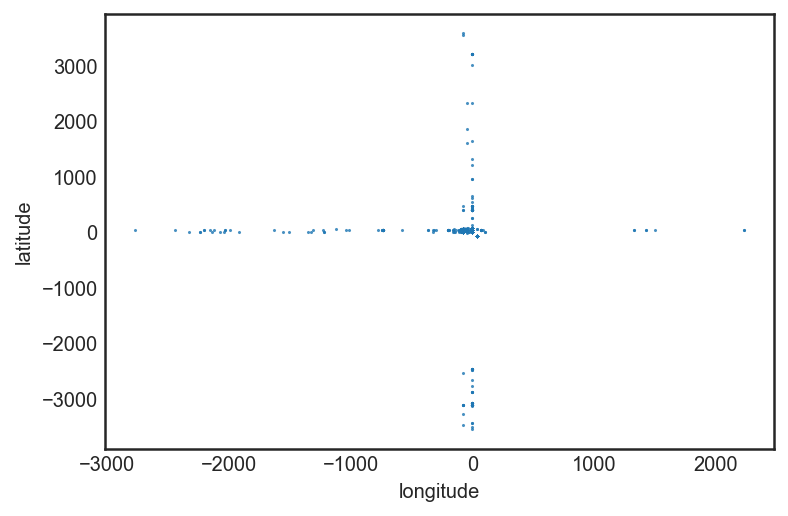

In [15]:
# Sanity Check Latitude and Longitude Values
longitude = list(trips_df.pickup_longitude) + list(trips_df.dropoff_longitude)
latitude = list(trips_df.pickup_latitude) + list(trips_df.dropoff_latitude)

trip_data = pd.DataFrame({'latitude': latitude, 'longitude': longitude})
sns.set_style("white")
ax = sns.regplot(x="longitude", y="latitude", data=trip_data, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})
plt.show()

In [16]:
# We have lots of extraneous points here. Let's pare this down to a latitude/longitude range around NYC
longitude_limit = [-74.027, -73.85]
latitude_limit = [40.67, 40.85]
trips_df2 = trips_df.copy()
trips_df2 = trips_df2[(trips_df2.pickup_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.dropoff_longitude.between(longitude_limit[0], longitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.pickup_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]
trips_df2 = trips_df2[(trips_df2.dropoff_latitude.between(latitude_limit[0], latitude_limit[1], inclusive=False))]

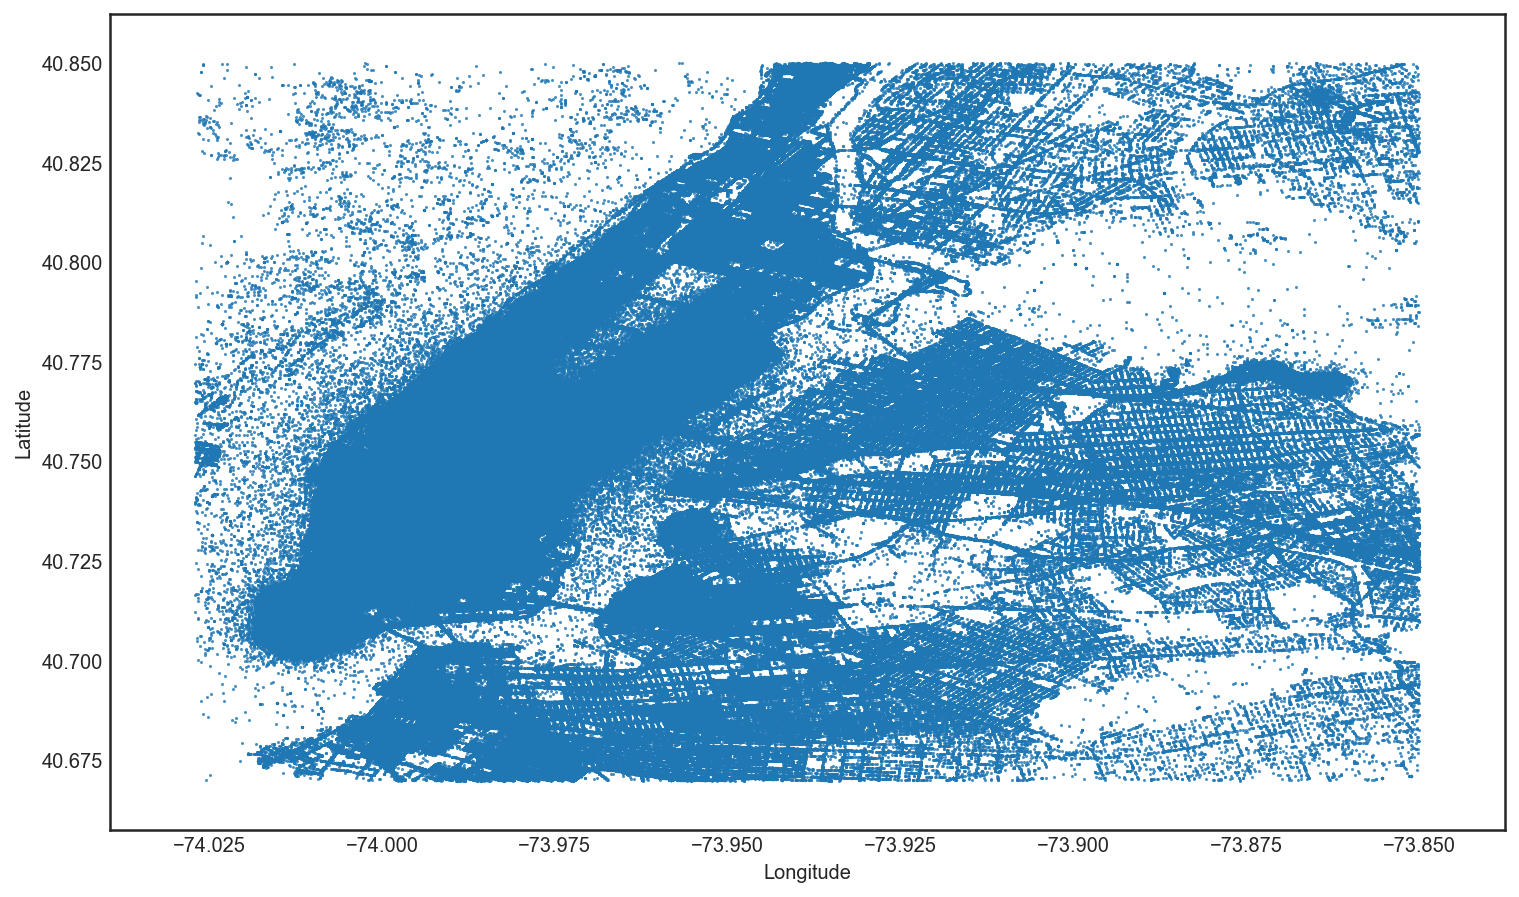

In [17]:
# Sanity Check Latitude and Longitude Values
longitude = list(trips_df2.pickup_longitude) + list(trips_df2.dropoff_longitude)
latitude = list(trips_df2.pickup_latitude) + list(trips_df2.dropoff_latitude)

trip_data2 = pd.DataFrame({'latitude': latitude, 'longitude': longitude})
sns.set_style("white")
fig, ax = plt.subplots(figsize=(12.5, 7.5))
ax = sns.regplot(x="longitude", y="latitude", data=trip_data2, scatter=True, fit_reg=False, scatter_kws={"s": 0.3})

ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
None

In [18]:
# How many trips are 0 secs?
trips_df2[trips_df2.trip_time_in_secs==0].shape[0]

8521

In [19]:
# How many trips are 0 miles?
trips_df2[trips_df2.trip_distance==0].shape[0]

67594

In [20]:
trips_df2 = trips_df2[trips_df2.trip_time_in_secs>0]
trips_df2 = trips_df2[trips_df2.trip_distance>0.0]

In [21]:
trips_df2.passenger_count.value_counts()

1    9996918
2    1843000
5     838081
6     572427
3     571377
4     278106
0         15
9          1
Name: passenger_count, dtype: int64

**Notes:**
NYC Taxi Law prohibits more than 4 people in a 4-person taxicab, or more than 5 people in a 5 person taxicab. It is possible to have 6 people in a 5 person cab, if the sixth person is a child under seven and sits on the adult's lap, according to: http://www.nyc.gov/html/tlc/html/faq/faq_pass.shtml


1. Remove all trips where trip_time_in_secs = 0
2. Remove all trips where trip_distance = 0 miles
3. Remove all trips where passenger_count = 0 or 9 passengers

In [22]:
# All trips with 1 - 6 passengers
trips_df2 = trips_df2[(trips_df2.passenger_count > 0)&(trips_df2.passenger_count < 7)]
trips_df2.passenger_count.value_counts()

1    9996918
2    1843000
5     838081
6     572427
3     571377
4     278106
Name: passenger_count, dtype: int64

In [23]:
trips_df2.head()

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
0,5558056,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064
3,12715560,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028
6,12744782,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716
7,12744785,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711
8,12744788,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556


In [24]:
trips_df2.describe()

,index,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
count,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07,1.409991e+07
mean,7.556602e+06,1.003854e+00,1.711673e+00,6.987419e+02,2.432293e+00,-7.397875e+01,4.075286e+01,-7.397720e+01,4.075299e+01
std,4.356831e+06,2.148441e-01,1.389176e+00,4.605265e+02,2.254664e+00,2.344111e-02,2.298818e-02,2.392735e-02,2.568499e-02
min,0.000000e+00,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067001e+01,-7.402699e+01,4.067000e+01
25%,3.795379e+06,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399250e+01,4.073791e+01,-7.399175e+01,4.073737e+01
50%,7.552780e+06,1.000000e+00,1.000000e+00,6.000000e+02,1.700000e+00,-7.398222e+01,4.075420e+01,-7.398089e+01,4.075462e+01
75%,1.133117e+07,1.000000e+00,2.000000e+00,9.000000e+02,2.940000e+00,-7.396901e+01,4.076823e+01,-7.396658e+01,4.076877e+01
max,1.510047e+07,2.100000e+02,6.000000e+00,1.057600e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01


In [25]:
trips_df2.shape[0]

14099909

## Load fares data from DB
---

In [26]:
query_string2 = '''
                select * from fares order by pickup_datetime asc
'''

In [27]:
# Connect to the existing fleetriskdb
con = sqlite3.connect('./DB/nyctaxidb.sqlite')
# Confirm data is being returned from this query
fare_data_df = pd.read_sql_query(query_string2, con)
# Verify that result of SQL query is stored in the dataframe
fare_data_df.tail()

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
15100463,3246544,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,2013-04-30 23:59:57,CSH,5.5,0.5,0.5,0.00,0.0,6.50
15100464,2942655,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,2013-04-30 23:59:58,CRD,14.5,0.5,0.5,2.00,0.0,17.50
15100465,3007208,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,2013-04-30 23:59:58,CRD,4.0,0.5,0.5,1.00,0.0,6.00
15100466,3007664,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,2013-04-30 23:59:58,CRD,7.5,0.5,0.5,1.11,0.0,9.61
15100467,3246968,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,2013-04-30 23:59:58,CSH,7.5,0.5,0.5,0.00,0.0,8.50


In [28]:
con.close()

In [29]:
fare_data_df.shape[0]

15100468

## Scrub fares data for outliers, if any.

In [30]:
# Check for nulls
fares_df = fare_data_df.copy()
fares_df.isnull().sum()

index              0
medallion          0
hack_license       0
vendor_id          0
pickup_datetime    0
payment_type       0
fare_amount        0
surcharge          0
mta_tax            0
tip_amount         0
tolls_amount       0
total_amount       0
dtype: int64

In [31]:
fares_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 15100468 entries, 0 to 15100467
Data columns (total 12 columns):
index              int64
medallion          object
hack_license       object
vendor_id          object
pickup_datetime    object
payment_type       object
fare_amount        float64
surcharge          float64
mta_tax            float64
tip_amount         float64
tolls_amount       float64
total_amount       float64
dtypes: float64(6), int64(1), object(5)
memory usage: 1.4+ GB


In [32]:
# Need to look into the $500 fare!
fares_df.describe()

,index,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07,1.510047e+07
mean,7.550234e+06,1.227417e+01,3.266898e-01,4.983206e-01,1.345662e+00,2.446353e-01,1.468948e+01
std,4.359130e+06,9.958736e+00,3.673146e-01,2.892903e-02,2.131956e+00,1.185930e+00,1.194023e+01
min,0.000000e+00,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,3.775117e+06,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,7.550234e+06,9.500000e+00,0.000000e+00,5.000000e-01,1.000000e+00,0.000000e+00,1.100000e+01
75%,1.132535e+07,1.400000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.650000e+01
max,1.510047e+07,5.000000e+02,1.500000e+01,5.000000e-01,2.000000e+02,2.000000e+01,6.281000e+02


In [33]:
fares_df[fares_df.fare_amount == 500]

,index,medallion,hack_license,vendor_id,pickup_datetime,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
208020,5900817,662302712A0D1A0CC0CFEE09C77E810A,C005B53076A215B1A73F409B17EC0A9C,CMT,2013-04-01 14:57:44,CRD,500.0,0.0,0.0,0.0,0.0,500.0
1982907,7174302,E1CCE8B14CCEE4F74AECD70A329FCE12,D047ADF5875661BFA8CF6B9832477424,CMT,2013-04-05 00:28:42,CRD,500.0,0.0,0.0,10.0,0.0,510.0
3982815,5938243,51E4B2515891E2A9B14B4A4EDCDD4A61,540881FB05E698CCB354C51563FF34FD,CMT,2013-04-09 02:42:32,CRD,500.0,0.0,0.0,100.0,0.0,600.0
6897450,5433524,D3BC1778F469C2671E9B68101D063080,F6DA525F59FA69F6E7843E2A471AE98E,CMT,2013-04-14 15:54:03,CRD,500.0,0.0,0.0,100.0,0.0,600.0
7956534,2138350,1109955CCAABCBCE1A22BCED5F1DBFF5,45D5908BA7B1E2F3BA424E66D81D7A30,CMT,2013-04-16 21:42:07,CRD,500.0,0.0,0.0,0.0,0.0,500.0
10994407,9287314,CA8DFBC7AF031CBABDD5A592DFB2741C,3C9179450CD0C023C36D35033062D894,CMT,2013-04-22 19:48:51,CRD,500.0,0.0,0.0,0.0,0.0,500.0
11167592,9287007,C2B48FE1ED15833D27B8C44667DDB878,9167C1802996E3C7D4E1777D46930646,CMT,2013-04-23 08:02:42,CRD,500.0,0.0,0.0,0.0,0.0,500.0
11265770,10286375,17A3D1C9C47C5B519AECCE5BB75625B4,C81E728D9D4C2F636F067F89CC14862C,CMT,2013-04-23 11:44:15,CSH,500.0,0.0,0.0,0.0,0.0,500.0
14825858,3225674,6203CEAAA0A019EB20A4D397DF014061,7DC21A197FECEFB70B2AE5E475A05030,CMT,2013-04-30 13:48:00,NOC,500.0,0.0,0.0,0.0,0.0,500.0


In [34]:
trips_df2.shape

(14099909, 14)

In [35]:
fares_df.shape

(15100468, 12)

## Merge Trips and Fares tables together
---

In [36]:
taxi_df = trips_df2.merge(fares_df, on=['medallion','hack_license','vendor_id','pickup_datetime'], how='inner')
taxi_df = taxi_df.drop(['index_x', 'index_y'], axis=1)
taxi_df.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01 00:00:00,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01 00:00:00,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01 00:00:00,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01 00:00:00,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01 00:00:00,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5


In [37]:
taxi_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 14100159 entries, 0 to 14100158
Data columns (total 20 columns):
medallion            object
hack_license         object
vendor_id            object
rate_code            int64
pickup_datetime      object
dropoff_datetime     object
passenger_count      int64
trip_time_in_secs    int64
trip_distance        float64
pickup_longitude     float64
pickup_latitude      float64
dropoff_longitude    float64
dropoff_latitude     float64
payment_type         object
fare_amount          float64
surcharge            float64
mta_tax              float64
tip_amount           float64
tolls_amount         float64
total_amount         float64
dtypes: float64(11), int64(3), object(6)
memory usage: 2.2+ GB


In [38]:
taxi_df.isnull().sum()

medallion            0
hack_license         0
vendor_id            0
rate_code            0
pickup_datetime      0
dropoff_datetime     0
passenger_count      0
trip_time_in_secs    0
trip_distance        0
pickup_longitude     0
pickup_latitude      0
dropoff_longitude    0
dropoff_latitude     0
payment_type         0
fare_amount          0
surcharge            0
mta_tax              0
tip_amount           0
tolls_amount         0
total_amount         0
dtype: int64

In [39]:
taxi_df.shape

(14100159, 20)

In [40]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07,1.410016e+07
mean,1.003856e+00,1.711671e+00,6.987400e+02,2.432294e+00,-7.397875e+01,4.075286e+01,-7.397720e+01,4.075299e+01,1.092214e+01,3.314330e-01,4.998537e-01,1.206128e+00,1.466119e-01,1.310617e+01
std,2.148501e-01,1.389173e+00,4.605280e+02,2.254677e+00,2.344112e-02,2.298819e-02,2.392732e-02,2.568501e-02,6.664937e+00,3.691019e-01,8.552866e-03,1.676072e+00,8.791101e-01,8.124970e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067001e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399250e+01,4.073791e+01,-7.399175e+01,4.073737e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.700000e+00,-7.398222e+01,4.075420e+01,-7.398089e+01,4.075462e+01,9.000000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.080000e+01
75%,1.000000e+00,2.000000e+00,9.000000e+02,2.940000e+00,-7.396901e+01,4.076823e+01,-7.396658e+01,4.076877e+01,1.300000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.550000e+01
max,2.100000e+02,6.000000e+00,1.057600e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.500100e+02,1.500000e+01,5.000000e-01,2.000000e+02,2.000000e+01,4.500100e+02


In [41]:
# Max fare amount is $450 - let's investigate
taxi_df[taxi_df.fare_amount == 450]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
2335387,29A25AEC480AEF1AFC7F00818D3A3FF5,C31309FBC712658C5E42537A123430F5,CMT,5,2013-04-05 23:06:49,2013-04-05 23:08:29,1,100,0.3,-74.002533,40.724911,-74.002533,40.724911,DIS,450.0,0.0,0.0,0.0,0.0,450.0


Use this data dictionary to determine what these codes mean, this seems like a 'Disputed' fare: http://www.nyc.gov/html/tlc/downloads/pdf/data_dictionary_trip_records_yellow.pdf 

In [42]:
#taxi_df.payment_type.value_counts(normalize=True)

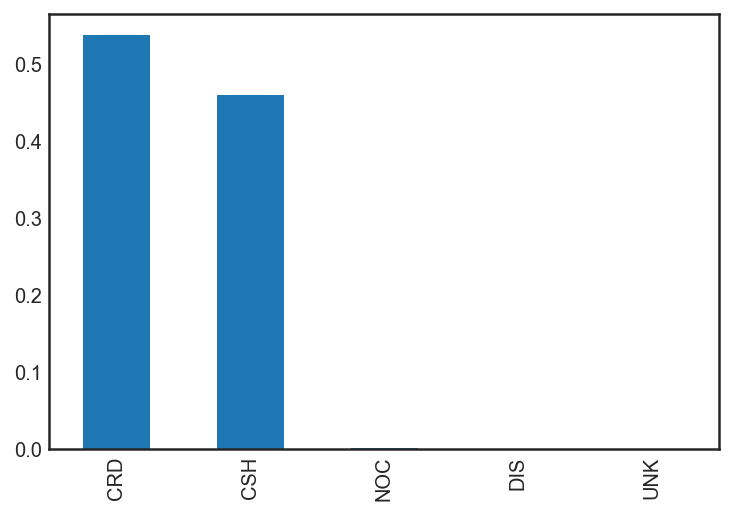

In [43]:
# Seems like a disputed fare - let's look at different payment types
taxi_df.payment_type.value_counts(normalize=True).plot(kind='bar')
None

In [44]:
# These other payment types make up a very small portion of our data
# Even though this will slightly bias our results, let's drop No Charge, Disputed or Unknown payment types
taxi_df = taxi_df[(taxi_df.payment_type == 'CRD')|(taxi_df.payment_type == 'CSH')]

In [45]:
taxi_df.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07,1.406407e+07
mean,1.003707e+00,1.712761e+00,6.989239e+02,2.432126e+00,-7.397875e+01,4.075286e+01,-7.397721e+01,4.075299e+01,1.092205e+01,3.313664e-01,4.998644e-01,1.208341e+00,1.465603e-01,1.310818e+01
std,2.141330e-01,1.390191e+00,4.602143e+02,2.251872e+00,2.343296e-02,2.298477e-02,2.391404e-02,2.567917e-02,6.653930e+00,3.691043e-01,8.232770e-03,1.676601e+00,8.787895e-01,8.117006e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067001e+01,-7.402699e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,2.500000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399250e+01,4.073791e+01,-7.399175e+01,4.073737e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.700000e+00,-7.398222e+01,4.075420e+01,-7.398089e+01,4.075463e+01,9.000000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.080000e+01
75%,1.000000e+00,2.000000e+00,9.000000e+02,2.940000e+00,-7.396902e+01,4.076823e+01,-7.396660e+01,4.076878e+01,1.300000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.550000e+01
max,2.100000e+02,6.000000e+00,1.057600e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,4.500100e+02,1.500000e+01,5.000000e-01,2.000000e+02,2.000000e+01,4.500100e+02


# Save Results to SQLite Database

In [136]:
import sqlite3
# Create a sqlite3 connection to nyctaxidb
cnxn = sqlite3.connect('nyctaximergeddb.sqlite')

In [137]:
# Create trips table
taxi_df.to_sql('merged',cnxn)

## Analysis Continues
---

In [46]:
# Max fare amount is $450 - let's investigate
taxi_df2 = taxi_df.copy()
taxi_df2[taxi_df2.fare_amount > 400]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
12374044,50296A056AF5D221536DC98ABB1E3274,A5E445844765D299EEFA07FF4B8F5A4C,CMT,5,2013-04-27 03:22:05,2013-04-27 03:23:21,1,76,0.4,-73.967026,40.754944,-73.9683,40.755051,CSH,450.01,0.0,0.0,0.0,0.0,450.01


Using the data dictionary here: http://www.nyc.gov/html/tlc/html/passenger/taxicab_rate.shtml 

* Rate Code 1 = Standard City Rate
* Rate Code 2 = JFK Airport Rate
* Rate Code 3 = La Guardia Airport Rate
* Rate Code 4 = Westchester/Nassau County Rates
* Rate Code 5 = Out of City Rate with negotiated flat fare

How many other fares like this exist?

In [47]:
taxi_df2.rate_code.value_counts()

1      14042882
4          8906
2          7057
5          3807
0           763
3           602
6            35
210          10
65            2
206           1
77            1
9             1
7             1
Name: rate_code, dtype: int64

In [48]:
# Looking at Rate Code 5 seems suspect for any future modeling we might like to do.
taxi_df2[taxi_df2.rate_code == 5].sort_values('fare_amount')

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
2165226,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-05 17:56:01,2013-04-05 18:08:22,1,740,2.00,-73.956261,40.768646,-73.976059,40.747341,CSH,2.50,0.0,0.5,0.00,0.00,3.00
4164360,0A84B25FD498B75D5DEDBC79858DAD07,20E3E6919A4F4BEB959AE2465E781B62,CMT,5,2013-04-10 01:00:00,2013-04-10 01:01:00,1,45,3.60,-74.001373,40.729240,-74.001389,40.729198,CRD,2.50,0.0,0.0,0.50,0.00,3.00
3682300,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-08 22:47:51,2013-04-08 23:05:46,2,1074,5.20,-73.987686,40.749546,-73.925377,40.766495,CSH,2.50,0.0,0.5,0.00,0.00,3.00
649627,BCF1C6D7A4822EFEEDC9DF4A465A09D4,749261B5765FFD0A0297EE2B05B33556,CMT,5,2013-04-02 16:03:18,2013-04-02 16:28:24,1,1505,7.80,-73.956078,40.764233,-73.892159,40.762527,CSH,2.50,0.0,0.0,0.00,5.33,7.83
3993800,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-09 18:10:50,2013-04-09 18:35:48,1,1498,3.30,-73.981186,40.759071,-73.996605,40.722092,CSH,2.50,0.0,0.5,0.00,0.00,3.00
759758,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-02 20:05:37,2013-04-02 20:17:05,1,687,2.70,-73.978188,40.762699,-73.973747,40.796291,CSH,2.50,0.0,0.5,0.00,0.00,3.00
2853748,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-06 23:38:46,2013-04-07 00:03:43,1,1496,1.90,-73.976479,40.765362,-73.997971,40.750584,CSH,2.50,0.0,0.5,0.00,0.00,3.00
2288941,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-05 21:44:01,2013-04-05 21:59:23,2,921,2.70,-73.982437,40.762341,-74.007408,40.741035,CSH,2.50,0.0,0.5,0.00,0.00,3.00
2372480,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-06 00:14:42,2013-04-06 00:26:36,2,714,3.00,-73.988960,40.745338,-73.957787,40.773682,CSH,2.50,0.0,0.5,0.00,0.00,3.00
2135603,BE2039FF3AAADDC4D17B9148151F9220,EDB2DE00B2C4087FE570AF794D62F87B,CMT,5,2013-04-05 16:31:46,2013-04-05 16:56:13,1,1467,2.70,-73.982903,40.771481,-74.003296,40.739208,CSH,2.50,0.0,0.5,0.00,0.00,3.00


In [49]:
# I pare this down to all city or the surrounding airports trips
taxi_df2 = taxi_df2[taxi_df2.rate_code < 4]
taxi_df2.shape[0]

14051304

In [50]:
taxi_df2.describe()

,rate_code,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
count,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07,1.405130e+07
mean,1.000534e+00,1.712959e+00,6.989062e+02,2.431436e+00,-7.397875e+01,4.075286e+01,-7.397721e+01,4.075299e+01,1.091121e+01,3.314440e-01,4.999755e-01,1.207282e+00,1.456752e-01,1.309558e+01
std,2.697442e-02,1.390452e+00,4.600216e+02,2.249590e+00,2.342846e-02,2.298445e-02,2.390756e-02,2.567681e-02,6.601285e+00,3.690962e-01,3.498608e-03,1.670389e+00,8.735230e-01,8.059507e+00
min,0.000000e+00,1.000000e+00,1.000000e+00,1.000000e-02,-7.402698e+01,4.067001e+01,-7.402698e+01,4.067000e+01,2.500000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,3.000000e+00
25%,1.000000e+00,1.000000e+00,3.600000e+02,1.030000e+00,-7.399250e+01,4.073791e+01,-7.399174e+01,4.073737e+01,6.500000e+00,0.000000e+00,5.000000e-01,0.000000e+00,0.000000e+00,8.000000e+00
50%,1.000000e+00,1.000000e+00,6.000000e+02,1.700000e+00,-7.398222e+01,4.075420e+01,-7.398089e+01,4.075463e+01,9.000000e+00,5.000000e-01,5.000000e-01,1.000000e+00,0.000000e+00,1.080000e+01
75%,1.000000e+00,2.000000e+00,9.000000e+02,2.940000e+00,-7.396902e+01,4.076823e+01,-7.396659e+01,4.076877e+01,1.300000e+01,5.000000e-01,5.000000e-01,2.000000e+00,0.000000e+00,1.550000e+01
max,3.000000e+00,6.000000e+00,1.057600e+04,1.000000e+02,-7.385001e+01,4.085000e+01,-7.385001e+01,4.085000e+01,2.040000e+02,5.500000e+00,5.000000e-01,2.000000e+02,2.000000e+01,2.285000e+02


In [51]:
taxi_df2[taxi_df2.fare_amount == taxi_df2.fare_amount.max()]

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
6594151,56EC8E3AA6218867A1341249F26531F3,59E86EC8FFE3A4941A7F6E6219A8A99A,CMT,1,2013-04-14 22:22:06,2013-04-15 00:51:24,1,8957,73.3,-73.980591,40.758259,-73.978142,40.757458,CSH,204.0,0.5,0.5,0.0,0.0,205.0


In [52]:
# Nearly 2.5 hour trip over 73 miles, paid by cash - seems legit
8957/3600.

2.4880555555555555

In [53]:
# 14 million trips
taxi_df2.shape[0]

14051304

In [54]:
# Two primary taxi vendors
#taxi_df.groupby('vendor_id')['medallion'].nunique()#.plot(kind='bar', color=[['yellow','black']])
#None

In [55]:
# 13,269 Taxis
taxi_df2.medallion.nunique()

13269

In [56]:
# 32,846 Drivers
taxi_df2.hack_license.nunique()

32846

In [57]:
# 34 million miles
taxi_df2.trip_distance.sum()

34164847.040000089

In [58]:
# $184 million
taxi_df2.total_amount.sum()

184010034.17999983

# Including Airport Routes
---

## 1. What is the distribution of the number of passengers per trip?

In [59]:
taxi_df2.passenger_count.value_counts()

1    9957491
2    1837429
5     837306
6     572004
3     569897
4     277177
Name: passenger_count, dtype: int64

In [60]:
taxi_df2.passenger_count.describe()

count    1.405130e+07
mean     1.712959e+00
std      1.390452e+00
min      1.000000e+00
25%      1.000000e+00
50%      1.000000e+00
75%      2.000000e+00
max      6.000000e+00
Name: passenger_count, dtype: float64

In [61]:
taxi_df2.passenger_count.mode()

0    1
dtype: int64

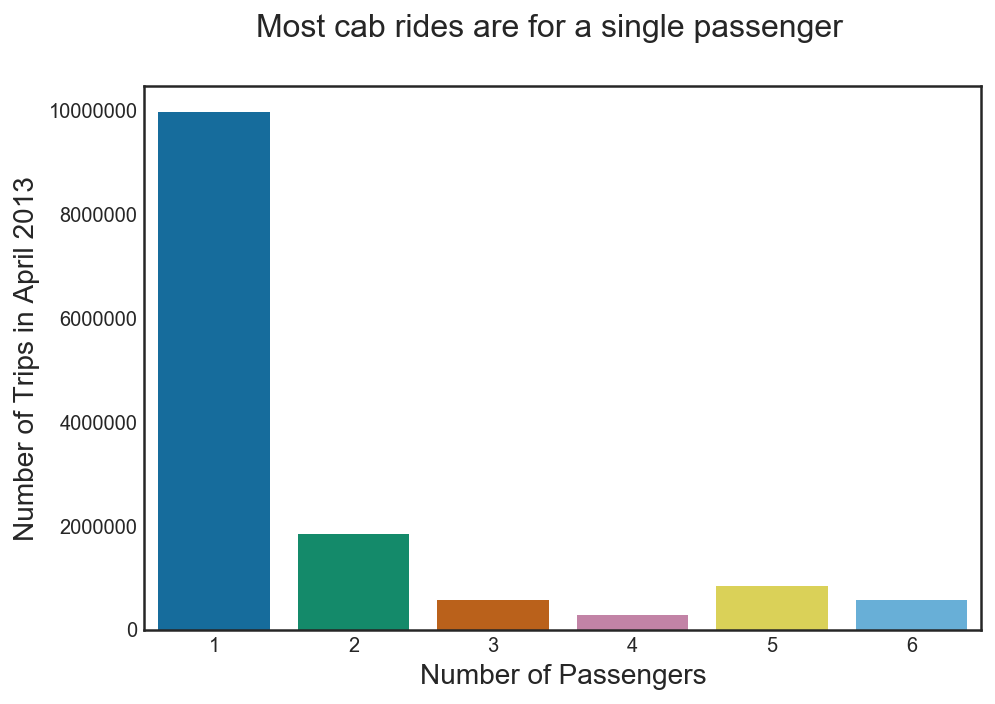

In [62]:
fig, ax = plt.subplots(figsize=(7.5,5))
fig.suptitle('Most cab rides are for a single passenger', fontsize=16)
ax = sns.countplot(x='passenger_count', data = taxi_df2, palette = 'colorblind', ax=ax)
ax.set_xlabel('Number of Passengers', fontsize=14)
ax.set_ylabel('Number of Trips in April 2013', fontsize=14)
plt.ticklabel_format(style='plain', axis='y')
None

## 2. What is the distribution of payment type?

In [63]:
a = taxi_df.payment_type.value_counts(normalize=True)
a = a.to_frame().reset_index()
a = a.rename(columns={'index':'Type', 'payment_type':'Frequency'})
a_df = a
a_df

,Type,Frequency
0,CRD,0.538956
1,CSH,0.461044


In [64]:
# Could have used a dictionary here instead
a_df = a_df.replace('CRD','Credit Card')
a_df = a_df.replace('CSH','Cash')
#a_df = a_df.replace('NOC','No Charge')
#a_df = a_df.replace('DIS', 'Dispute')
#a_df = a_df.replace('UNK','Unknown')
a_df.set_index('Type', inplace=True)

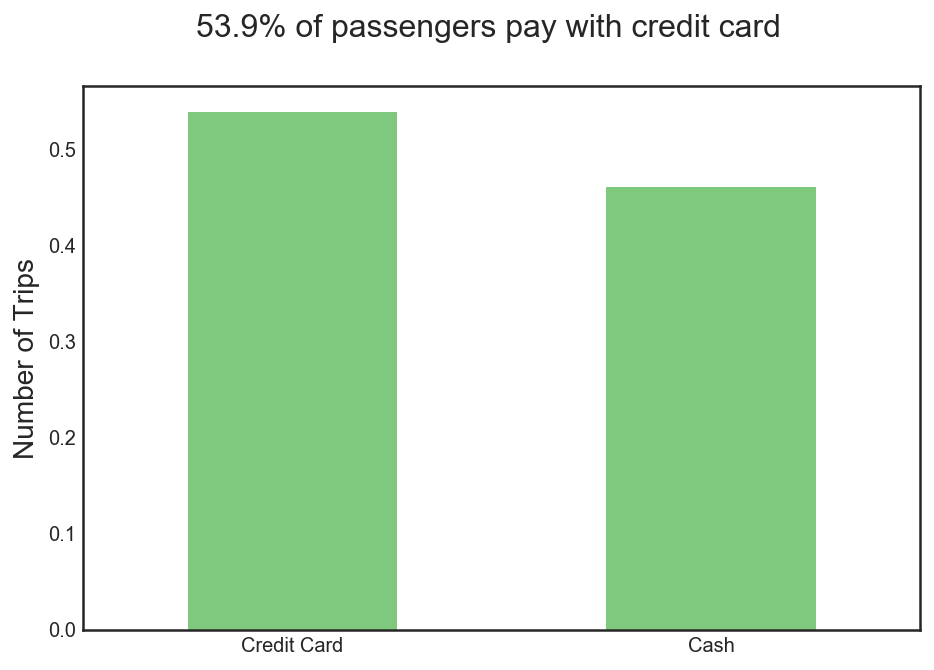

In [66]:
fig, ax = plt.subplots(figsize=(7.5,5))
ax = a_df.plot(kind='bar', cmap='Accent', legend=False, rot=0, ax=ax)
ax.set_xlabel('')
ax.set_ylabel('Number of Trips', fontsize=14)
fig.suptitle('53.9% of passengers pay with credit card', fontsize=16)
plt.ticklabel_format(style='plain', axis='y')
None

## 3. What is the distribution of the fare amount?

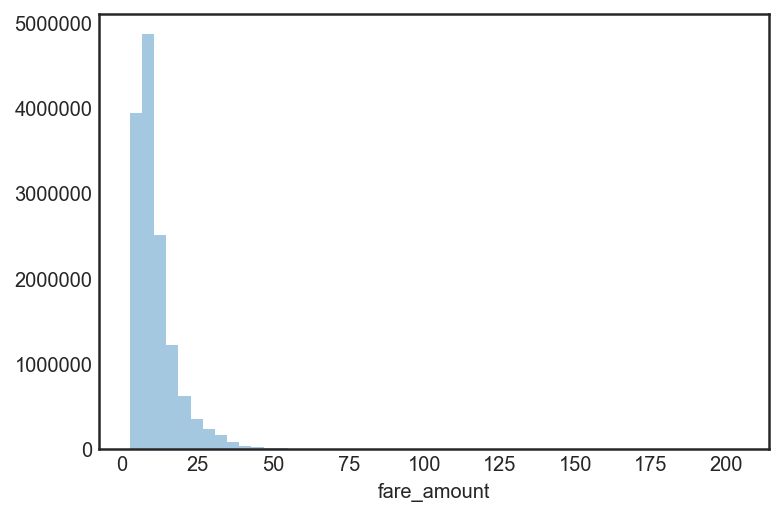

In [71]:
ax = sns.distplot(taxi_df2.fare_amount, kde=False)

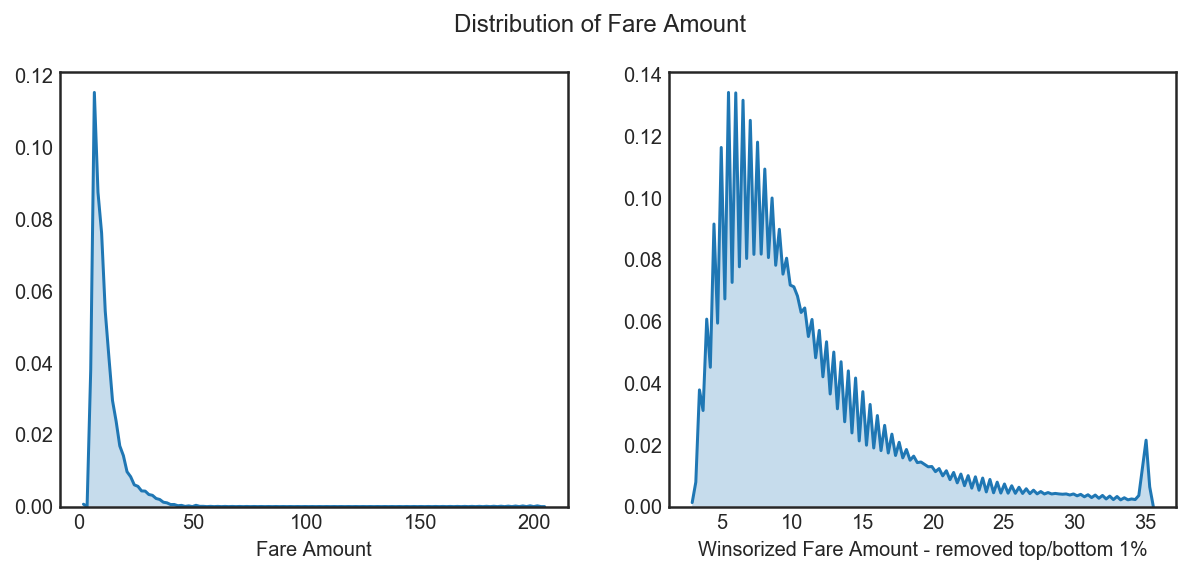

In [68]:
(fig, ax) = plt.subplots(1,2, figsize=(10,4))
ax[0] = sns.kdeplot(taxi_df2.fare_amount, legend=False, ax=ax[0], shade=True)
# Remove top and bottom 1% of fare amounts
ax[1] = sns.kdeplot(winsorize(taxi_df2.fare_amount, limits=[0.01, 0.01]), legend=False, ax=ax[1], shade=True)
ax[0].set_xlabel('Fare Amount')
ax[1].set_xlabel('Winsorized Fare Amount - removed top/bottom 1%')
fig.suptitle('Distribution of Fare Amount')
None

In [74]:
winsorized_fare_amt = winsorize(taxi_df2.fare_amount, limits=[0.01, 0.01])
fare_amt_median = np.median(winsorized_fare_amt)

fare_amt_lower = stats.scoreatpercentile(winsorized_fare_amt, 5)
fare_amt_upper = stats.scoreatpercentile(winsorized_fare_amt, 95)

print fare_amt_lower, fare_amt_median, fare_amt_upper

4.5 9.0 24.5


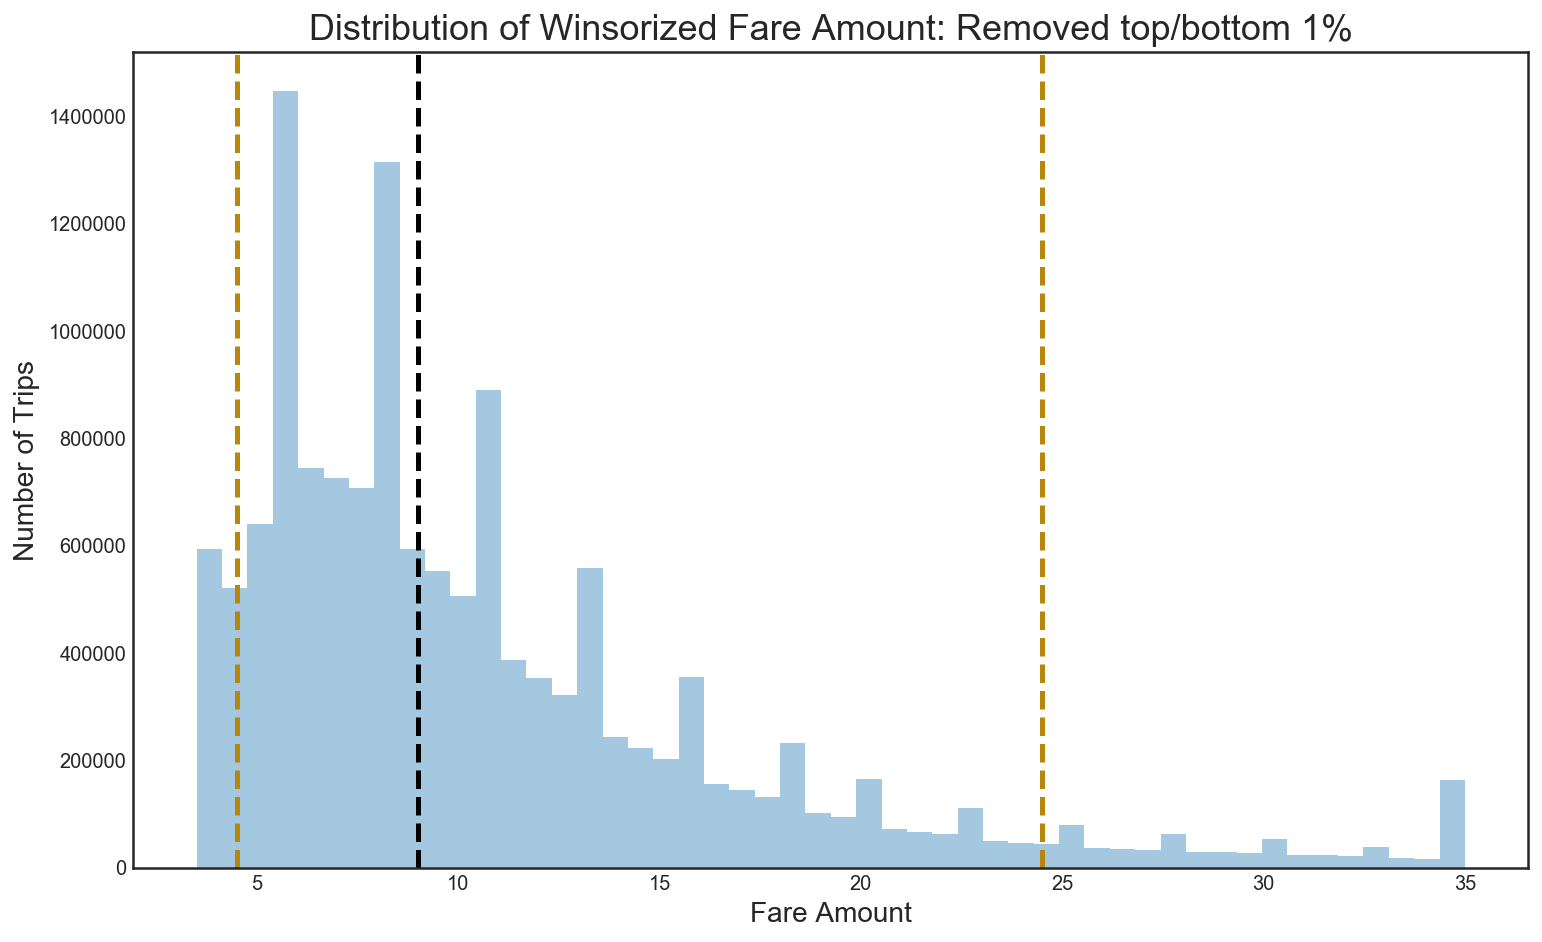

In [75]:
(fig, ax) = plt.subplots(figsize=(12.5,7.5))
ax = sns.distplot(winsorized_fare_amt, kde=False)
ax.axvline(fare_amt_median, lw=2.5, ls='dashed', color='black')
ax.axvline(fare_amt_lower, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.axvline(fare_amt_upper, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.set_title('Distribution of Winsorized Fare Amount: Removed top/bottom 1%', fontsize=18)
ax.set_xlabel('Fare Amount', fontsize=14)
ax.set_ylabel('Number of Trips', fontsize=14)
None

## 4. What is the distribution of the tip amount?

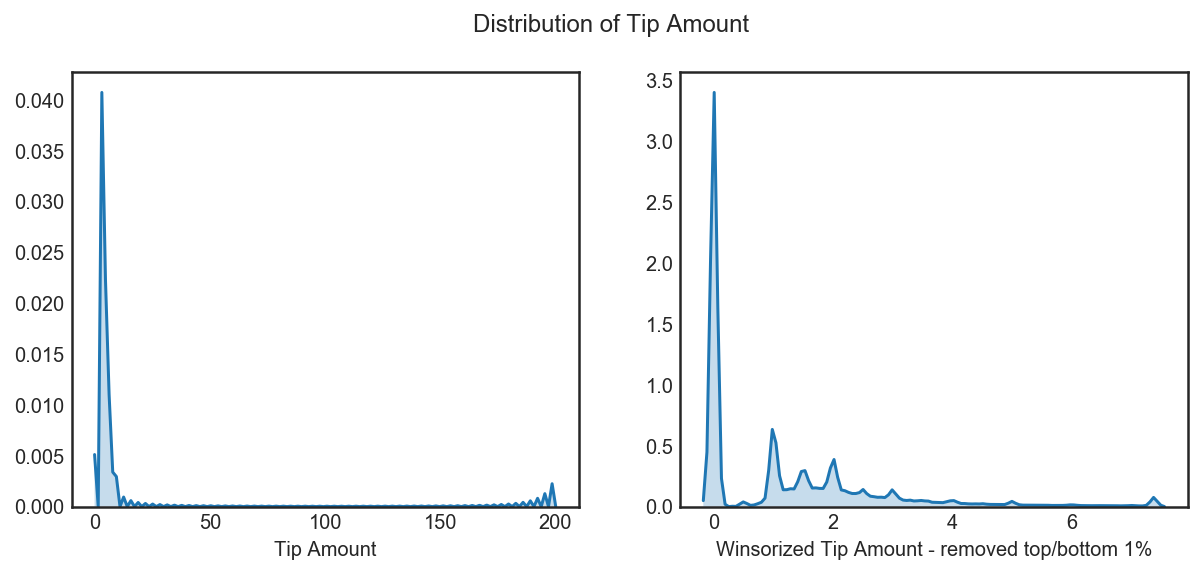

In [76]:
(fig, ax) = plt.subplots(1,2, figsize=(10,4))
ax[0] = sns.kdeplot(taxi_df2.tip_amount, legend=False, ax=ax[0], shade=True)
# Remove top and bottom 1% of fare amounts
ax[1] = sns.kdeplot(winsorize(taxi_df.tip_amount, limits=[0.01, 0.01]), legend=False, ax=ax[1], shade=True)
ax[0].set_xlabel('Tip Amount')
ax[1].set_xlabel('Winsorized Tip Amount - removed top/bottom 1%')
fig.suptitle('Distribution of Tip Amount')
None

In [77]:
winsorized_tip_amt = winsorize(taxi_df2.tip_amount, limits=[0.01, 0.01])
tip_amt_median = np.median(winsorized_tip_amt)

tip_amt_lower = stats.scoreatpercentile(winsorized_tip_amt, 5)
tip_amt_upper = stats.scoreatpercentile(winsorized_tip_amt, 95)

print tip_amt_lower, tip_amt_median, tip_amt_upper

0.0 1.0 4.2


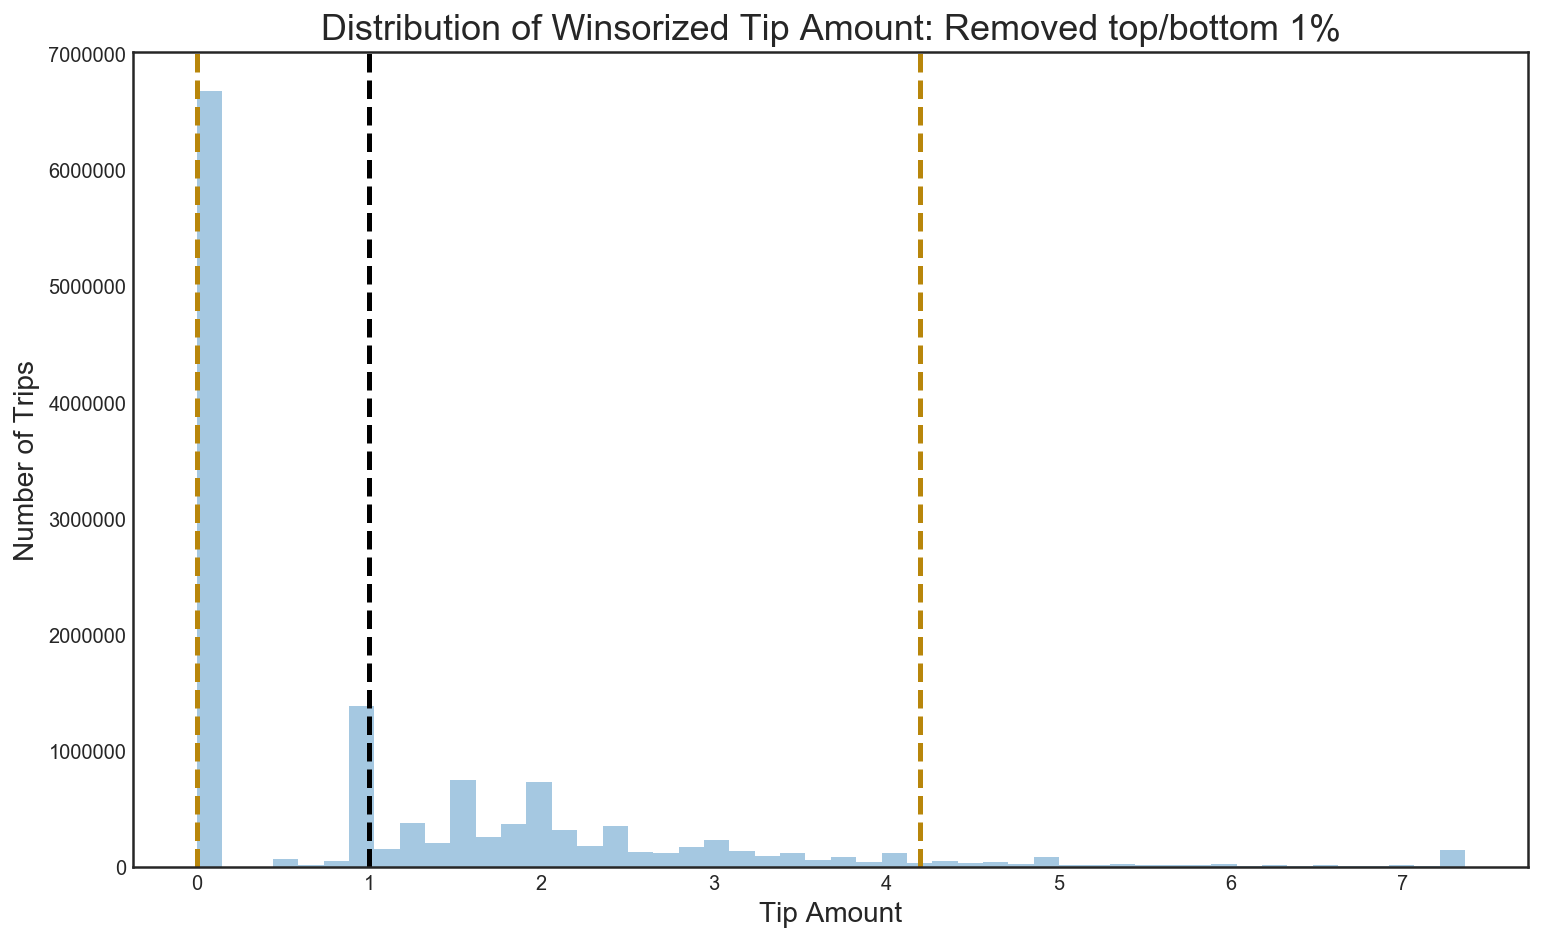

In [78]:
(fig, ax) = plt.subplots(figsize=(12.5,7.5))
ax = sns.distplot(winsorized_tip_amt, kde=False)
ax.axvline(tip_amt_median, lw=2.5, ls='dashed', color='black')
ax.axvline(tip_amt_lower, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.axvline(tip_amt_upper, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.set_title('Distribution of Winsorized Tip Amount: Removed top/bottom 1%', fontsize=18)
ax.set_xlabel('Tip Amount', fontsize=14)
ax.set_ylabel('Number of Trips', fontsize=14)
None

## 5. What is the distribution of the Total Amount?

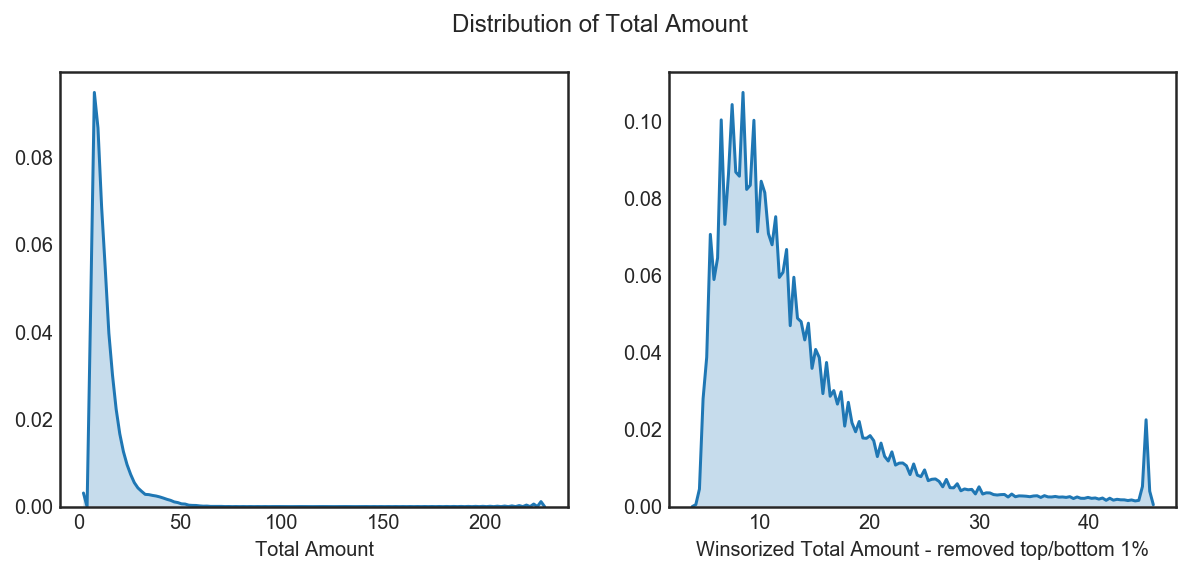

In [79]:
(fig, ax) = plt.subplots(1,2, figsize=(10,4))
ax[0] = sns.kdeplot(taxi_df2.total_amount, legend=False, ax=ax[0], shade=True)
# Remove top and bottom 1% of fare amounts
ax[1] = sns.kdeplot(winsorize(taxi_df.total_amount, limits=[0.01, 0.01]), legend=False, ax=ax[1], shade=True)
ax[0].set_xlabel('Total Amount')
ax[1].set_xlabel('Winsorized Total Amount - removed top/bottom 1%')
fig.suptitle('Distribution of Total Amount')
None

In [80]:
winsorized_tot_amt = winsorize(taxi_df2.total_amount, limits=[0.01, 0.01])
tot_amt_median = np.median(winsorized_tot_amt)

tot_amt_lower = stats.scoreatpercentile(winsorized_tot_amt, 5)
tot_amt_upper = stats.scoreatpercentile(winsorized_tot_amt, 95)

print tot_amt_lower, tot_amt_median, tot_amt_upper

5.5 10.8 29.25


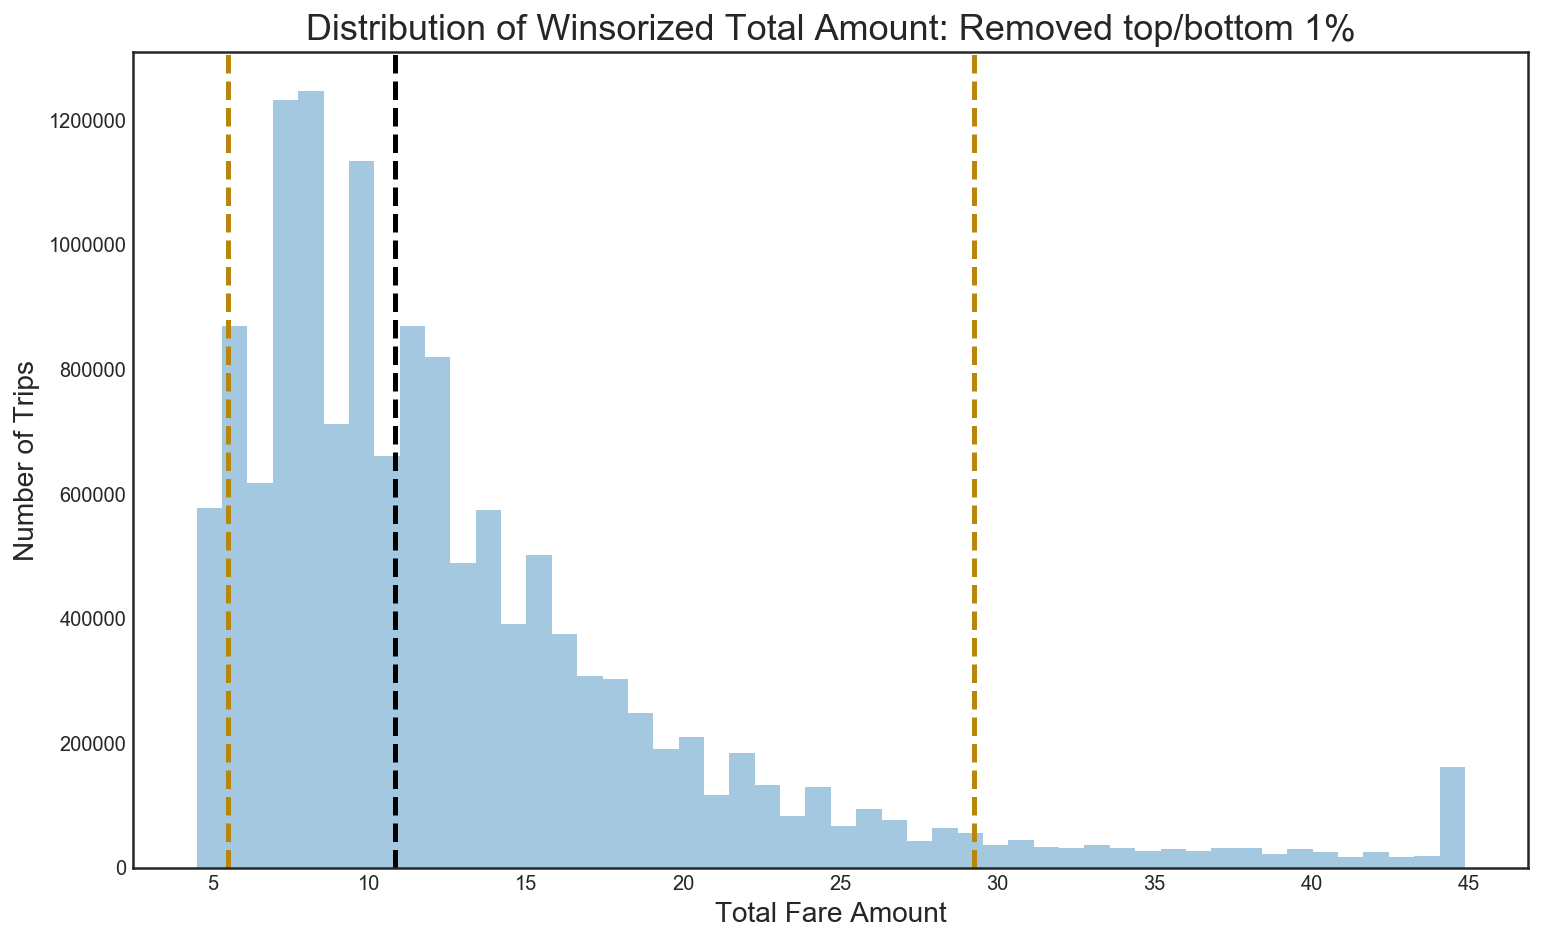

In [81]:
(fig, ax) = plt.subplots(figsize=(12.5,7.5))
ax = sns.distplot(winsorized_tot_amt, kde=False)
ax.axvline(tot_amt_median, lw=2.5, ls='dashed', color='black')
ax.axvline(tot_amt_lower, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.axvline(tot_amt_upper, lw=2.5, color='darkgoldenrod', ls='dashed')
ax.set_title('Distribution of Winsorized Total Amount: Removed top/bottom 1%', fontsize=18)
ax.set_xlabel('Total Fare Amount', fontsize=14)
ax.set_ylabel('Number of Trips', fontsize=14)
None

## 6. What are the top 5 busiest hours of the day?

In [82]:
# Convert pickup_datetime and dropoff_datetime to datetime format
taxi_df2['pickup_datetime'] = pd.to_datetime(taxi_df2['pickup_datetime'])
taxi_df2['dropoff_datetime'] = pd.to_datetime(taxi_df2['dropoff_datetime'])
taxi_df2.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5


In [83]:
# Use pickup datetime to determine hour e.g. if someone was picked up at 23:15:16, they were picked up at 2300 hours
taxi_df2.groupby(taxi_df2.pickup_datetime.dt.hour)['passenger_count'].sum().sort_values(ascending=False)

pickup_datetime
19    1545779
18    1489456
20    1484616
21    1431625
22    1388223
23    1204435
14    1202275
12    1187912
17    1183035
15    1153323
13    1147676
9     1145639
11    1133674
8     1111067
10    1103101
16     956354
0      915116
7      884093
1      657969
2      494071
6      453626
3      355824
4      247778
5      192635
Name: passenger_count, dtype: int64

In [85]:
b = taxi_df2.groupby(taxi_df2.pickup_datetime.dt.hour)['passenger_count'].sum().sort_values(ascending=False).head()
b = b.to_frame().reset_index()
b = b.rename(columns={'pickup_datetime': 'hour'})
b_df = b.copy()
b_df

,hour,passenger_count
0,19,1545779
1,18,1489456
2,20,1484616
3,21,1431625
4,22,1388223


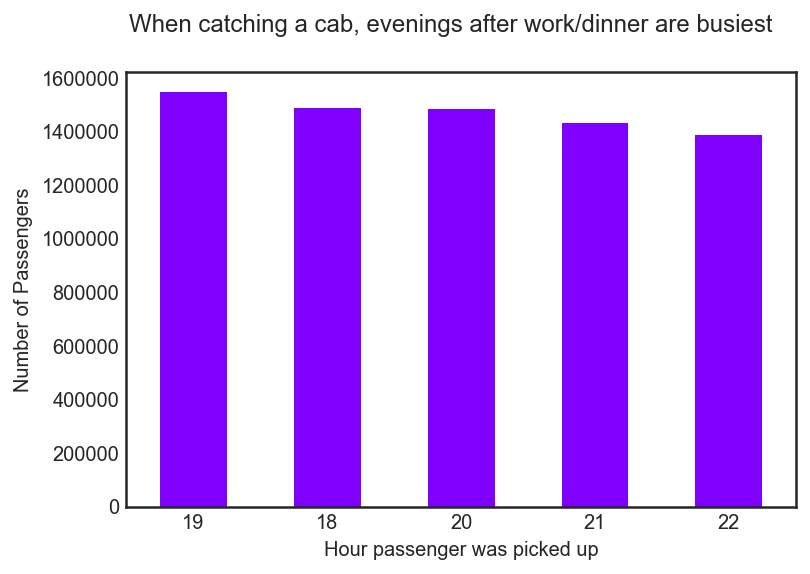

In [86]:
fig, ax = plt.subplots(figsize=(6,4))
ax = b_df.set_index('hour').plot(kind='bar', colormap='rainbow', legend=False, rot=0, ax=ax)
ax.set_xlabel('Hour passenger was picked up')
ax.set_ylabel('Number of Passengers')
fig.suptitle('When catching a cab, evenings after work/dinner are busiest')
plt.ticklabel_format(style='plain', axis='y')
None

In [87]:
taxi_df2['DayofWeek'] = taxi_df2.pickup_datetime.dt.weekday_name
taxi_df2['Hour'] = taxi_df2.pickup_datetime.dt.hour
taxi_df2.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,DayofWeek,Hour
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.993500,40.746933,-73.956322,40.773064,CRD,12.0,0.5,0.5,2.6,0.0,15.6,Monday,0
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.917908,40.770863,-73.899574,40.754028,CSH,34.0,0.5,0.5,0.0,0.0,35.0,Monday,0
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.959290,40.719727,-73.966736,40.710716,CRD,5.0,0.5,0.5,1.1,0.0,7.1,Monday,0
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.990929,40.760746,-74.003082,40.741711,CRD,7.5,0.5,0.5,2.0,0.0,10.5,Monday,0
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.970650,40.758587,-73.979584,40.737556,CRD,7.0,0.5,0.5,1.5,0.0,9.5,Monday,0


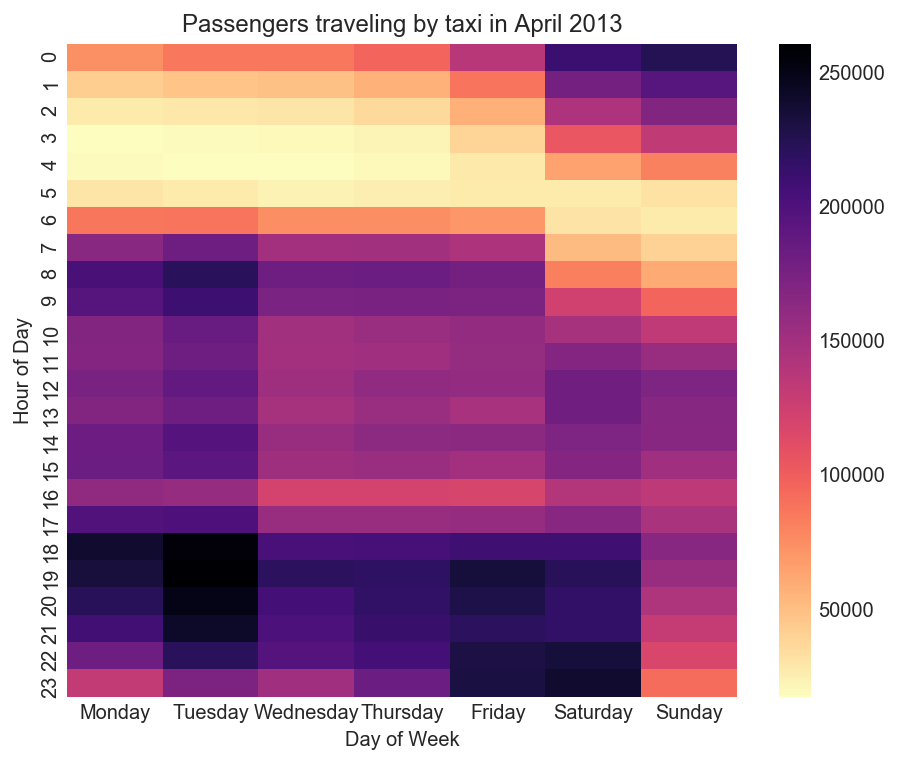

In [88]:
# What are the busiest days and hours for taxi drivers?
busiest_df = taxi_df2.groupby(['DayofWeek','Hour'])['passenger_count'].sum().reset_index()
busiest_piv = pd.pivot_table(busiest_df, values="passenger_count",index=["Hour"], columns=["DayofWeek"], fill_value=0)
busiest_piv = busiest_piv[['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']]
#plot pivot table as heatmap using seaborn
fig, ax = plt.subplots(figsize=(7.5,6))
#im = ax.imshow(busiest_piv, cmap="Greens")
#fig.colorbar(im, ax=ax)
ax = sns.heatmap(busiest_piv, ax=ax, cmap='magma_r')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Hour of Day')
ax.set_title('Passengers traveling by taxi in April 2013')
None

## 7. What are the top 10 busiest locations in the city?

In [89]:
# 2 d.p. of precision will suffice
taxi_df3 = taxi_df2.copy()
taxi_df3['pickup_latitude'] = taxi_df3.pickup_latitude.round(2)
taxi_df3['pickup_longitude'] = taxi_df3.pickup_longitude.round(2)
taxi_df3['dropoff_latitude'] = taxi_df3.dropoff_latitude.round(2)
taxi_df3['dropoff_longitude'] = taxi_df3.dropoff_longitude.round(2)
taxi_df3.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,DayofWeek,Hour
14100154,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.00,0.0,6.50,Tuesday,23
14100155,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.00,0.0,17.50,Tuesday,23
14100156,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.00,0.0,6.00,Tuesday,23
14100157,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.94,40.78,-73.94,40.78,CRD,7.5,0.5,0.5,1.11,0.0,9.61,Tuesday,23
14100158,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.00,0.0,8.50,Tuesday,23


In [90]:
taxi_df3['pickup_geocode'] = taxi_df3.pickup_latitude.astype(str) + ', ' + taxi_df3.pickup_longitude.astype(str)
taxi_df3['dropoff_geocode'] = taxi_df3.dropoff_latitude.astype(str) + ', ' + taxi_df3.dropoff_longitude.astype(str)
taxi_df3.tail()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,DayofWeek,Hour,pickup_geocode,dropoff_geocode
14100154,D10870DF96A6A201337FF2EF5B3D893D,287F30AEA8CF3242D100EC3CFF5BE2DA,CMT,1,2013-04-30 23:59:57,2013-05-01 00:03:37,1,219,1.0,-73.98,40.78,-73.99,40.77,CSH,5.5,0.5,0.5,0.00,0.0,6.50,Tuesday,23,"40.78, -73.98","40.77, -73.99"
14100155,CB0CF7051AAD729BD1F030EC42E3AAFB,69D7B9A38A419958A40EC9F299642F17,CMT,1,2013-04-30 23:59:58,2013-05-01 00:16:44,1,1006,4.2,-73.98,40.76,-74.00,40.74,CRD,14.5,0.5,0.5,2.00,0.0,17.50,Tuesday,23,"40.76, -73.98","40.74, -74.0"
14100156,1948C5FBB3E9E807D27074F528465F90,00C2CDB494E2163E6B83204FE5AAE516,CMT,1,2013-04-30 23:59:58,2013-05-01 00:02:52,2,173,0.6,-73.98,40.78,-73.98,40.77,CRD,4.0,0.5,0.5,1.00,0.0,6.00,Tuesday,23,"40.78, -73.98","40.77, -73.98"
14100157,A8262FA0AFCB6C7229F6888EAFBDE076,5F9351CC273E38A49A6CD691FFF5B980,CMT,1,2013-04-30 23:59:58,2013-05-01 00:06:38,1,399,1.7,-73.94,40.78,-73.94,40.78,CRD,7.5,0.5,0.5,1.11,0.0,9.61,Tuesday,23,"40.78, -73.94","40.78, -73.94"
14100158,CC75E7B29C4D32F9A45F6582F448C789,1BC47AA485CD2C61E65A2CA57C690918,CMT,1,2013-04-30 23:59:58,2013-05-01 00:07:16,1,438,1.7,-74.00,40.73,-73.99,40.75,CSH,7.5,0.5,0.5,0.00,0.0,8.50,Tuesday,23,"40.73, -74.0","40.75, -73.99"


## 7a. What are the most popular pickup locations and zipcodes?

In [91]:
pickup = taxi_df3.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(10)
pickup = pickup.to_frame().rename(columns={'pickup_geocode':'Number of Trips'}).reset_index()
pickup_df = pickup.copy()
pickup_df = pickup_df.rename(columns={'pickup_geocode':'Pickup_Geocode'})
pickup_df['location'] = pickup_df.Pickup_Geocode.apply(geolocator.reverse)
pickup_df['address'] = [i.address for i in pickup_df.location]
pickup_df['address'] = pickup_df['address'].astype(str)
pickup_df['zipcode'] = pickup_df['address'].str.extract('(\d{5})', expand=True).astype(int)
pickup_df.drop('location',axis=1,inplace=True)
pickup_df

,Pickup_Geocode,Number of Trips,address,zipcode
0,"40.76, -73.97",898910,"664, Lexington Avenue, Lenox Hill, Manhattan Community Board 8, New York County, NYC, New York, 10022, United States of America",10022
1,"40.75, -73.99",798813,"137, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
2,"40.76, -73.98",737145,"1270 Avenue of the Americas, 1270, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10020, United States of America",10020
3,"40.75, -73.98",726282,"35, East 38th Street, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America",10016
4,"40.74, -73.99",671492,"10, East 21st Street, Manhattan Community Board 6, New York County, NYC, New York, 10010, United States of America",10010
5,"40.76, -73.99",627726,"341, West 45th Street, Hell's Kitchen, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America",10036
6,"40.73, -73.99",521644,"51 Astor Place, East 9th Street, East Village, Manhattan Community Board 3, New York County, NYC, New York, 10003, United States of America",10003
7,"40.77, -73.96",509157,"203, East 72nd Street, Upper East Side, Manhattan Community Board 8, New York County, NYC, New York, 10021, United States of America",10021
8,"40.77, -73.98",467888,"25, Central Park West, Upper West Side, Manhattan Community Board 7, New York County, NYC, New York, 10022, United States of America",10022
9,"40.73, -74.0",454819,"Filomen D'agostino Residence Hall, 110, West 3rd Street, NoHo Historic District, Manhattan Community Board 2, New York County, NYC, New York, 10012, United States of America",10012


In [92]:
pickup_df['Number of Trips'].sum()

6413876

## 7b. What are the most popular dropoff locations and zipcodes?

In [93]:
dropoff = taxi_df3.groupby('dropoff_geocode')['dropoff_geocode'].count().sort_values(ascending=False).head(10)
dropoff = dropoff.to_frame().rename(columns={'dropoff_geocode':'Number of Trips'}).reset_index()
dropoff_df = dropoff.copy()
dropoff_df = dropoff_df.rename(columns={'dropoff_geocode':'Dropoff_Geocode'})
dropoff_df['location'] = dropoff_df.Dropoff_Geocode.apply(geolocator.reverse)
dropoff_df['address'] = [i.address for i in dropoff_df.location]
dropoff_df['address'] = dropoff_df['address'].astype(str)
dropoff_df['zipcode'] = dropoff_df['address'].str.extract('(\d{5})', expand=True).astype(int)
dropoff_df.drop('location',axis=1,inplace=True)
dropoff_df

,Dropoff_Geocode,Number of Trips,address,zipcode
0,"40.76, -73.97",825111,"664, Lexington Avenue, Lenox Hill, Manhattan Community Board 8, New York County, NYC, New York, 10022, United States of America",10022
1,"40.76, -73.98",804845,"1270 Avenue of the Americas, 1270, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10020, United States of America",10020
2,"40.75, -73.99",747636,"137, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
3,"40.75, -73.98",727179,"35, East 38th Street, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America",10016
4,"40.74, -73.99",593305,"10, East 21st Street, Manhattan Community Board 6, New York County, NYC, New York, 10010, United States of America",10010
5,"40.76, -73.99",522215,"341, West 45th Street, Hell's Kitchen, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America",10036
6,"40.77, -73.96",494186,"203, East 72nd Street, Upper East Side, Manhattan Community Board 8, New York County, NYC, New York, 10021, United States of America",10021
7,"40.73, -73.99",432165,"51 Astor Place, East 9th Street, East Village, Manhattan Community Board 3, New York County, NYC, New York, 10003, United States of America",10003
8,"40.77, -73.98",402405,"25, Central Park West, Upper West Side, Manhattan Community Board 7, New York County, NYC, New York, 10022, United States of America",10022
9,"40.73, -74.0",398679,"Filomen D'agostino Residence Hall, 110, West 3rd Street, NoHo Historic District, Manhattan Community Board 2, New York County, NYC, New York, 10012, United States of America",10012


In [94]:
dropoff_df['Number of Trips'].sum()

5947726

Note the pickup and dropoff address geocodes are identical. The most popular locations are in Manhattan.

In [95]:
pickup_df['Number of Trips'].sum() + dropoff_df['Number of Trips'].sum()

12361602

## 8. Which trip has the highest standard deviation of travel times?
---

A trip is defined as combination of a pickup geocode and a dropoff geocode. What minimum sample size do we need to calculate this standard deviation?

* Margin of Error = 5%
* Confidence Interval = 95% which is a Z-Score of 1.96
* Standard Deviation = 0.5 (expecting 50% standard deviation will ensure large enough sample size)

Necessary Sample Size = ((1.96 x 0.5)/0.05)^2 = 384.16 = 385 trips

In [96]:
taxi_df4 = taxi_df3.copy()
# Creating trips with a combination of pickup and dropoff codes
taxi_df4['route'] = taxi_df4.pickup_geocode + ' : ' + taxi_df4.dropoff_geocode
taxi_df4.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,DayofWeek,Hour,pickup_geocode,dropoff_geocode,route
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.99,40.75,-73.96,40.77,CRD,12.0,0.5,0.5,2.6,0.0,15.6,Monday,0,"40.75, -73.99","40.77, -73.96","40.75, -73.99 : 40.77, -73.96"
1,B8733215A7E6A22EB832EEAEA731D3CB,66707B80913E62642A6C2E0BFEE45955,VTS,1,2013-04-01,2013-04-01 00:35:00,1,2100,10.29,-73.92,40.77,-73.90,40.75,CSH,34.0,0.5,0.5,0.0,0.0,35.0,Monday,0,"40.77, -73.92","40.75, -73.9","40.77, -73.92 : 40.75, -73.9"
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.96,40.72,-73.97,40.71,CRD,5.0,0.5,0.5,1.1,0.0,7.1,Monday,0,"40.72, -73.96","40.71, -73.97","40.72, -73.96 : 40.71, -73.97"
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.99,40.76,-74.00,40.74,CRD,7.5,0.5,0.5,2.0,0.0,10.5,Monday,0,"40.76, -73.99","40.74, -74.0","40.76, -73.99 : 40.74, -74.0"
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.97,40.76,-73.98,40.74,CRD,7.0,0.5,0.5,1.5,0.0,9.5,Monday,0,"40.76, -73.97","40.74, -73.98","40.76, -73.97 : 40.74, -73.98"


In [97]:
# Filter down to routes with more than 385 trips
taxi_df4 = taxi_df4.groupby('route').filter(lambda x: len(x) > 385)
taxi_df4.head()

,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,payment_type,fare_amount,surcharge,mta_tax,tip_amount,tolls_amount,total_amount,DayofWeek,Hour,pickup_geocode,dropoff_geocode,route
0,52BC28EAABDDC48741F825000D738850,DA77BDC1BC5CFD0E31613E7E2FF4EA24,CMT,1,2013-04-01,2013-04-01 00:10:32,1,632,3.40,-73.99,40.75,-73.96,40.77,CRD,12.0,0.5,0.5,2.6,0.0,15.6,Monday,0,"40.75, -73.99","40.77, -73.96","40.75, -73.99 : 40.77, -73.96"
2,D80FD255D1921207A256F30136F4DBB2,871954A11B0687C7C43B0E782AAEC9F1,VTS,1,2013-04-01,2013-04-01 00:04:00,4,240,0.97,-73.96,40.72,-73.97,40.71,CRD,5.0,0.5,0.5,1.1,0.0,7.1,Monday,0,"40.72, -73.96","40.71, -73.97","40.72, -73.96 : 40.71, -73.97"
3,23966E68120CC7347D4CE2FA60C133CD,EA554CB787C4BE0D1F90E9C5B2009A4F,VTS,1,2013-04-01,2013-04-01 00:06:00,1,360,1.69,-73.99,40.76,-74.00,40.74,CRD,7.5,0.5,0.5,2.0,0.0,10.5,Monday,0,"40.76, -73.99","40.74, -74.0","40.76, -73.99 : 40.74, -74.0"
4,67541D5955294F42CC3044A0950ECE2F,379099329932F1F8D72CB0F2DAC17525,VTS,1,2013-04-01,2013-04-01 00:05:00,1,300,1.82,-73.97,40.76,-73.98,40.74,CRD,7.0,0.5,0.5,1.5,0.0,9.5,Monday,0,"40.76, -73.97","40.74, -73.98","40.76, -73.97 : 40.74, -73.98"
5,975EF587DDCAB5070B2C1C62309D86AD,71AFE02FC67FC11A8B4CE79805EA5CA0,VTS,1,2013-04-01,2013-04-01 00:08:00,1,480,1.81,-73.98,40.75,-73.99,40.76,CRD,8.0,0.5,0.5,1.0,0.0,10.0,Monday,0,"40.75, -73.98","40.76, -73.99","40.75, -73.98 : 40.76, -73.99"


In [98]:
# Check
taxi_df4.groupby('route').size().sort_values(ascending=True).head()

route
40.8, -73.96 : 40.75, -73.97     386
40.76, -73.95 : 40.76, -73.99    386
40.7, -73.99 : 40.68, -74.0      386
40.74, -74.0 : 40.79, -73.94     386
40.74, -74.01 : 40.81, -73.95    386
dtype: int64

In [99]:
## Which trip has the highest standard deviation of travel times?
taxi_df4.groupby('route')['trip_time_in_secs'].std().sort_values(ascending=False).head(10)

route
40.77, -73.86 : 40.77, -73.86    901.540177
40.77, -73.87 : 40.77, -73.87    740.880991
40.77, -73.86 : 40.76, -74.0     733.126770
40.77, -73.86 : 40.69, -73.98    728.400965
40.77, -73.87 : 40.68, -73.98    706.411043
40.77, -73.87 : 40.68, -73.96    696.651888
40.77, -73.86 : 40.75, -74.0     689.391972
40.77, -73.86 : 40.68, -73.98    682.629484
40.77, -73.87 : 40.76, -74.0     679.576199
40.77, -73.87 : 40.74, -74.01    676.038369
Name: trip_time_in_secs, dtype: float64

In [119]:
# Trip 1 - within the airport (terminal to terminal?)
start_loc = geolocator.reverse("40.77, -73.86")
print start_loc.address

D5, Delta Departures, East Elmhurst, Queens County, NYC, New York, 11368, United States of America


In [102]:
end_loc = geolocator.reverse("40.77, -73.86")
print start_loc.address

D5, Delta Departures, East Elmhurst, Queens County, NYC, New York, 11368, United States of America


In [103]:
# Trip 2 - within the airport (terminal to terminal?)
start_loc = geolocator.reverse("40.77, -73.87")
print start_loc.address

Aloft New York LaGuardia Airport, 100-15, Ditmars Boulevard, North Beach, Queens County, NYC, New York, 11369, United States of America


In [105]:
end_loc = geolocator.reverse("40.77, -73.87")
print start_loc.address

Aloft New York LaGuardia Airport, 100-15, Ditmars Boulevard, North Beach, Queens County, NYC, New York, 11369, United States of America


In [106]:
# Trip 3 - Airport Route
start_loc = geolocator.reverse("40.77, -73.86")
print start_loc.address

D5, Delta Departures, East Elmhurst, Queens County, NYC, New York, 11368, United States of America


In [107]:
end_loc = geolocator.reverse("40.76, -74.0")
print end_loc.address

525, 11th Avenue, Hell's Kitchen, Manhattan Community Board 4, New York County, NYC, New York, 10018, United States of America


In [108]:
# Trip 4 - Airport Route
start_loc = geolocator.reverse("40.77, -73.86")
print start_loc.address

D5, Delta Departures, East Elmhurst, Queens County, NYC, New York, 11368, United States of America


In [109]:
end_loc = geolocator.reverse("40.69, -73.98")
print end_loc.address

85, DeKalb Avenue, Fort Greene, Kings County, NYC, New York, 11201, United States of America


In [143]:
# Trip 5 - Airport Route
start_loc = geolocator.reverse("40.77, -73.87")
print start_loc.address

C65, Terminal 2 Departures, Bayswater, Queens County, NYC, New York, 11434, United States of America


In [110]:
end_loc = geolocator.reverse("40.68, -73.98")
print end_loc.address

636, Baltic Street, Gowanus Houses, BK, Kings County, NYC, New York, 11217, United States of America


In [112]:
# Trip 6 - Airport Route
start_loc = geolocator.reverse("40.77, -73.87")
print start_loc.address

Aloft New York LaGuardia Airport, 100-15, Ditmars Boulevard, North Beach, Queens County, NYC, New York, 11369, United States of America


In [113]:
end_loc = geolocator.reverse("40.68, -73.96")
print end_loc.address

1030, Atlantic Avenue, Prospect Heights, BK, Kings County, NYC, New York, 11238, United States of America


In [114]:
# Trip 7 - Airport Route
start_loc = geolocator.reverse("40.77, -73.86")
print start_loc.address

D5, Delta Departures, East Elmhurst, Queens County, NYC, New York, 11368, United States of America


In [115]:
end_loc = geolocator.reverse("40.75, -74.0")
print end_loc.address

Chelsea Park, West 28th Street, Penn Station South, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America


## 9. Which trip has the most consistent fares?
---
Looking for those routes where standard deviation of fare amounts is among the lowest.

In [116]:
taxi_df4.groupby('route')['fare_amount'].std().sort_values(ascending=True).head(10)

route
40.72, -73.96 : 40.73, -73.94    0.974884
40.77, -73.9 : 40.78, -73.91     0.975118
40.81, -73.97 : 40.79, -73.98    1.012915
40.78, -73.99 : 40.79, -73.98    1.047566
40.81, -73.96 : 40.79, -73.98    1.196363
40.83, -73.95 : 40.81, -73.96    1.197004
40.81, -73.97 : 40.79, -73.97    1.222226
40.78, -73.96 : 40.78, -73.94    1.245601
40.82, -73.95 : 40.8, -73.97     1.254734
40.79, -73.98 : 40.8, -73.97     1.260590
Name: fare_amount, dtype: float64

In [120]:
# Trip 1
start_loc = geolocator.reverse("40.72, -73.96")
print start_loc.address

150, Wythe Avenue, Greenpoint, Kings County, NYC, New York, 11249, United States of America


In [121]:
end_loc = geolocator.reverse("40.73, -73.94")
print end_loc.address

360, Kingsland Avenue, Kings County, NYC, New York, 11222, United States of America


In [122]:
# Trip 2
start_loc = geolocator.reverse("40.77, -73.9")
print start_loc.address

21-51, 48th Street, Steinway, Queens County, NYC, New York, 11105, United States of America


In [124]:
end_loc = geolocator.reverse("40.78, -73.96")
print end_loc.address

17, East 84th Street, Upper East Side, Manhattan Community Board 8, New York County, NYC, New York, 10028, United States of America


In [125]:
# Trip 3
start_loc = geolocator.reverse("40.81, -73.97")
print start_loc.address

Hudson River Greenway, Morningside Heights, Manhattan Community Board 9, New York County, NYC, New York, 10025, United States of America


In [126]:
end_loc = geolocator.reverse("40.79, -73.98")
print end_loc.address

The Normandy, 140, Riverside Drive, Upper West Side, Manhattan Community Board 7, New York County, NYC, New York, 10024, United States of America


In [132]:
# Trip 4
start_loc = geolocator.reverse("40.78, -73.99")
print start_loc.address

500, East 14th Street, Manhattan Community Board 6, New York County, NYC, New York, 10009, United States of America


In [127]:
end_loc = geolocator.reverse("40.79, -73.98")
print end_loc.address

The Normandy, 140, Riverside Drive, Upper West Side, Manhattan Community Board 7, New York County, NYC, New York, 10024, United States of America


In [128]:
# Trip 5
start_loc = geolocator.reverse("40.81, -73.96")
print start_loc.address

Teachers College, West 120th Street, Morningside Heights, Manhattan Community Board 9, New York County, NYC, New York, 10027, United States of America


In [129]:
end_loc = geolocator.reverse("40.79, -73.98")
print end_loc.address

The Normandy, 140, Riverside Drive, Upper West Side, Manhattan Community Board 7, New York County, NYC, New York, 10024, United States of America


# Misc Code below: please ignore

In [155]:
# What are the 10 most popular taxicab pickup locations?
taxi_df3.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(10)

pickup_geocode
40.751, -73.994    14765
40.769, -73.863    13644
40.75, -73.992     13587
40.75, -73.991     12395
40.774, -73.871    11811
40.774, -73.873    11049
40.757, -73.99      9816
40.756, -73.991     9163
40.752, -73.978     8950
40.645, -73.782     8742
Name: pickup_geocode, dtype: int64

In [239]:
e_df['zipcode'] = e_df['address'].str.extract('(\d{5})', expand=True).astype(int)
e_df

,Dropoff,Number of Trips,address,zipcode
0,"40.75, -73.991",13597,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America",10001
1,"40.75, -73.995",10836,"410, 8th Avenue, Chelsea, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America",10001
2,"40.751, -73.991",10013,"200, West 34th Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
3,"40.749, -73.992",9933,"Emigrant Savings Bank, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America",10001
4,"40.762, -73.979",6196,"1321, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10019, United States of America",10019
5,"40.752, -73.978",6115,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America",10016
6,"40.774, -73.871",5911,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America",11368
7,"40.75, -73.992",5842,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America",10001
8,"40.757, -73.99",5676,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America",10036
9,"40.752, -73.977",5500,"GCT, 89, East 42nd Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America",10017


In [156]:
# Convert popular pickup locations into a dataframe
c = taxi_df3.groupby('pickup_geocode')['pickup_geocode'].count().sort_values(ascending=False).head(10)
c = c.to_frame().rename(columns={'pickup_geocode':'Number of Trips'}).reset_index()
c_df = c.copy()
c_df = c_df.rename(columns={'pickup_geocode':'Pickup'})
c_df

,Pickup,Number of Trips
0,"40.751, -73.994",14765
1,"40.769, -73.863",13644
2,"40.75, -73.992",13587
3,"40.75, -73.991",12395
4,"40.774, -73.871",11811
5,"40.774, -73.873",11049
6,"40.757, -73.99",9816
7,"40.756, -73.991",9163
8,"40.752, -73.978",8950
9,"40.645, -73.782",8742


In [234]:
e_df['address'] = e_df['address'].astype(str)
e_df

,Dropoff,Number of Trips,address
0,"40.75, -73.991",13597,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America"
1,"40.75, -73.995",10836,"410, 8th Avenue, Chelsea, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
2,"40.751, -73.991",10013,"200, West 34th Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
3,"40.749, -73.992",9933,"Emigrant Savings Bank, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
4,"40.762, -73.979",6196,"1321, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10019, United States of America"
5,"40.752, -73.978",6115,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America"
6,"40.774, -73.871",5911,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America"
7,"40.75, -73.992",5842,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
8,"40.757, -73.99",5676,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America"
9,"40.752, -73.977",5500,"GCT, 89, East 42nd Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America"


In [233]:
e = taxi_df3.groupby('dropoff_geocode')['dropoff_geocode'].count().sort_values(ascending=False).head(10)
e = e.to_frame().rename(columns={'dropoff_geocode':'Number of Trips'}).reset_index()
e_df = e.copy()
e_df = e_df.rename(columns={'dropoff_geocode':'Dropoff'})
e_df['location'] = e_df.Dropoff.apply(geolocator.reverse)
e_df['address'] = [i.address for i in e_df.location]
e_df.drop('location',axis=1,inplace=True)
e_df

,Dropoff,Number of Trips,address
0,"40.75, -73.991",13597,"Hotel Pennsylvania, 401, 7th Avenue, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001-2062, United States of America"
1,"40.75, -73.995",10836,"410, 8th Avenue, Chelsea, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
2,"40.751, -73.991",10013,"200, West 34th Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
3,"40.749, -73.992",9933,"Emigrant Savings Bank, West 31st Street, Manhattan Community Board 4, New York County, NYC, New York, 10001, United States of America"
4,"40.762, -73.979",6196,"1321, 6th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10019, United States of America"
5,"40.752, -73.978",6115,"One Grand Central Place, 120, Park Avenue, Manhattan Community Board 5, New York County, NYC, New York, 10016, United States of America"
6,"40.774, -73.871",5911,"Discover NY, Central Terminal Drive, North Beach, Queens County, NYC, New York, 11368, United States of America"
7,"40.75, -73.992",5842,"Two Penn Plaza, 2, West 33rd Street, Koreatown, Manhattan Community Board 5, New York County, NYC, New York, 10001, United States of America"
8,"40.757, -73.99",5676,"11 Times Square, 11, 8th Avenue, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10036, United States of America"
9,"40.752, -73.977",5500,"GCT, 89, East 42nd Street, Diamond District, Manhattan Community Board 5, New York County, NYC, New York, 10017, United States of America"


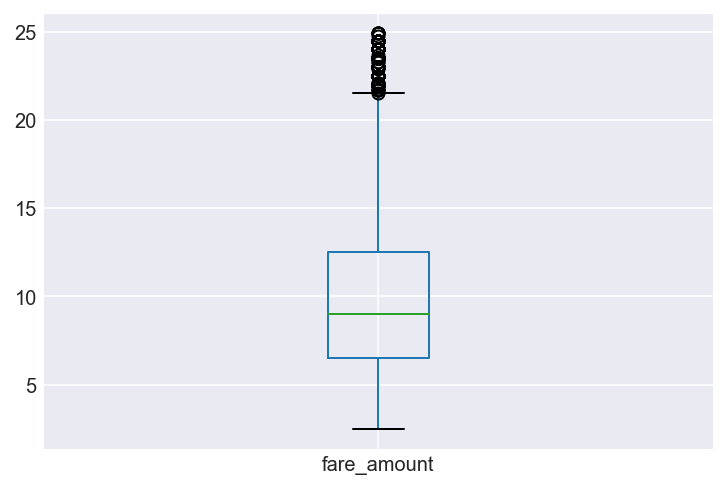

In [52]:
taxi_df[taxi_df.fare_amount<25].boxplot('fare_amount')
None

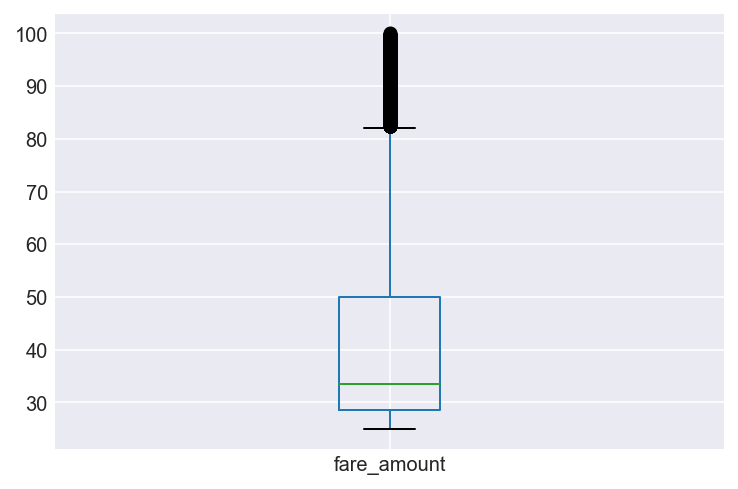

In [53]:
taxi_df[(taxi_df.fare_amount>=25)&(taxi_df.fare_amount<100)].boxplot('fare_amount')
None

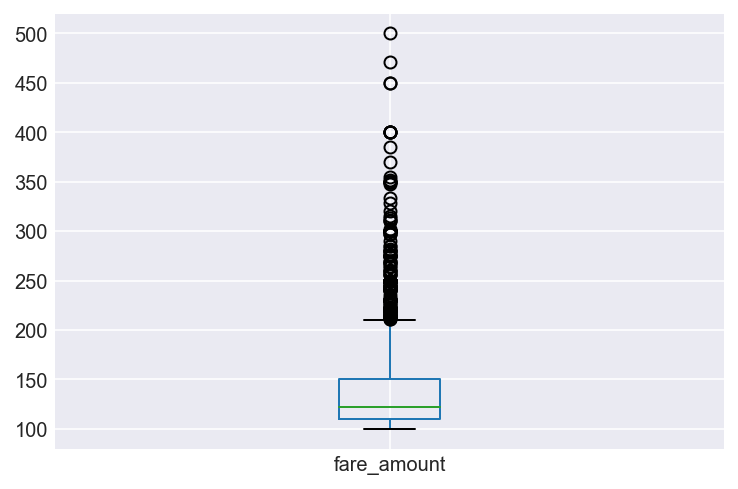

In [54]:
taxi_df[taxi_df.fare_amount>100].boxplot('fare_amount')
None

## Charting the five most popular pickup locations

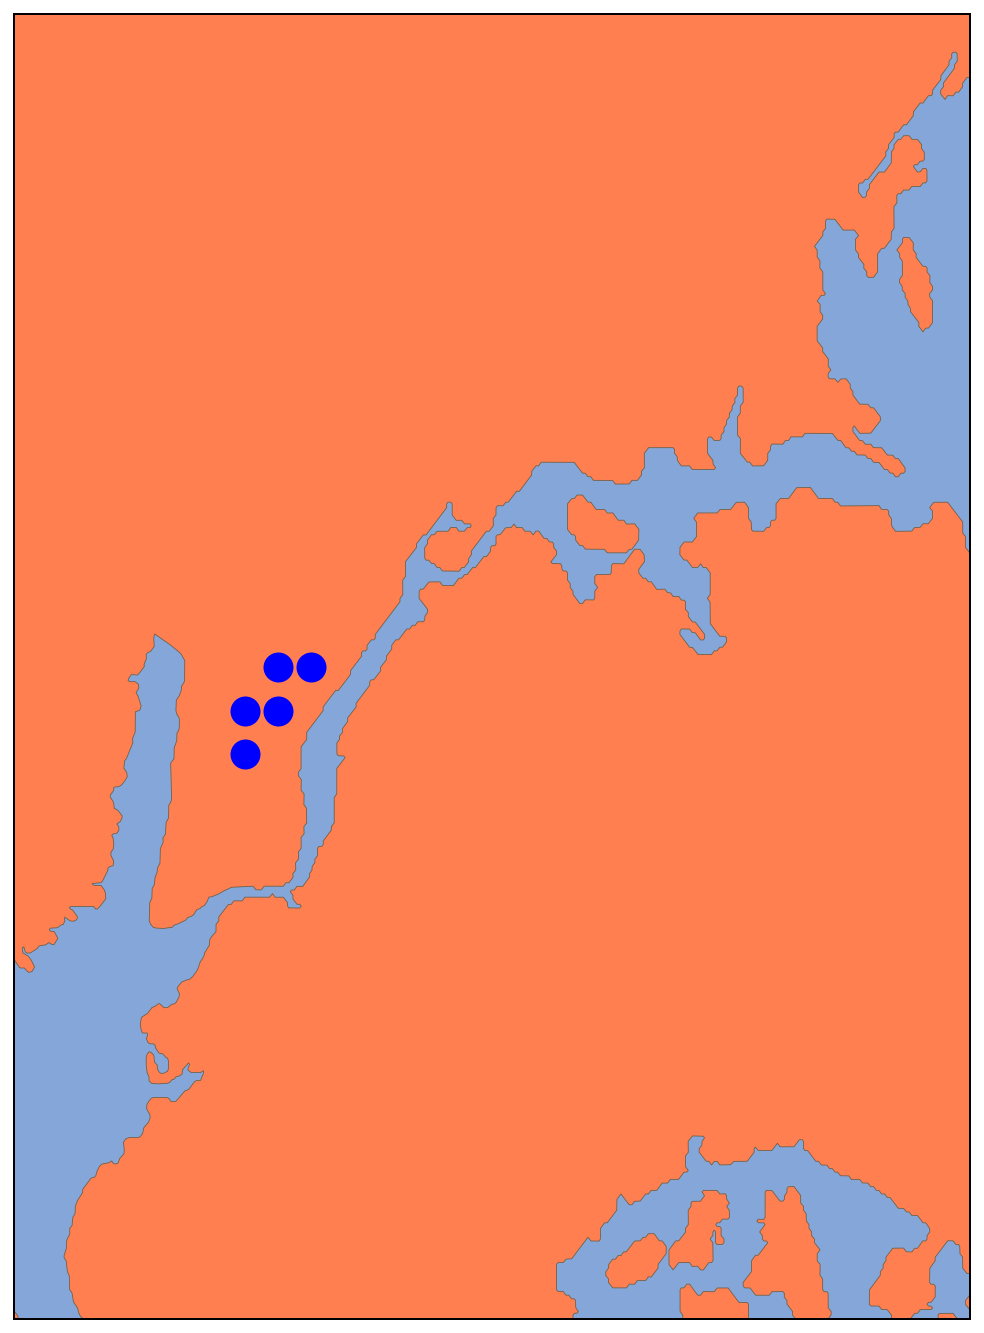

In [254]:
fig, ax = plt.subplots(figsize=(12.5,12))
plt.style.use = 'default'
m = Basemap(projection='merc',llcrnrlat=40.61,urcrnrlat=40.91,\
            llcrnrlon=-74.06, urcrnrlon=-73.77, lat_ts=40.5, 
            resolution='f')
m.drawmapboundary(fill_color='#85A6D9')
m.drawcoastlines(color='#6D5F47', linewidth=.4)
m.drawrivers(color='#6D5F47', linewidth=.4)
m.fillcontinents(color='coral',lake_color='#85A6D9')

lons = [-73.97, -73.99, -73.98, -73.98, -73.99]
lats = [40.76, 40.75, 40.76, 40.75, 40.74]
x,y = m(lons, lats)
m.plot(x,y,'bo', markersize=14)

plt.show()

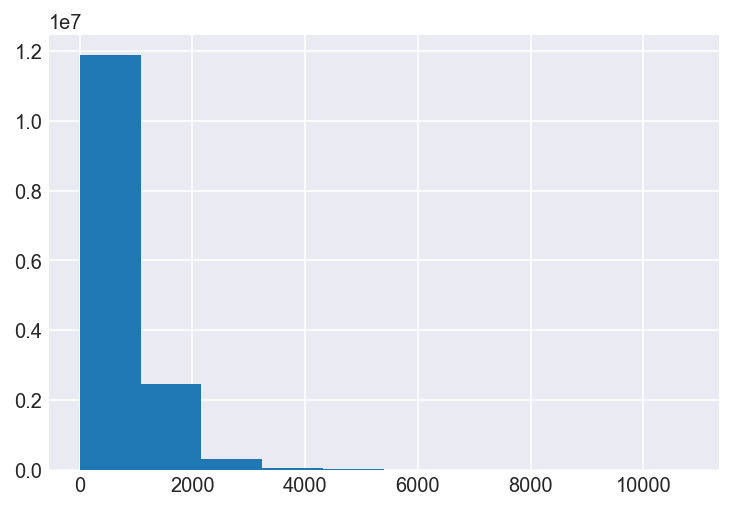

In [191]:
taxi_df2.trip_time_in_secs.hist()
None

In [23]:
# Make sure we don't have any erroneous lat/long values
trips_df = trips_df[(trips_df.pickup_latitude <> 0.0) & (trips_df.pickup_longitude <> 0.0)]
trips_df = trips_df[(trips_df.dropoff_latitude <> 0.0) & (trips_df.dropoff_longitude <> 0.0)]
trips_df[trips_df.pickup_latitude==0.0]

,index,medallion,hack_license,vendor_id,rate_code,pickup_datetime,dropoff_datetime,passenger_count,trip_time_in_secs,trip_distance,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude
